# Temporal and Spatial Analysis of Red Alerts in Israel

## Project Description

This project analyzes the **temporal and spatial patterns** of red alerts in Israel, covering the period from **December 26, 2018, to January 19, 2025**. The study examines **alert frequency, timing trends, geographical distribution, and alarm types**, providing insights into escalation dynamics and regional impact.

The dataset is sourced from the [Cumta Telegram channel](https://t.me/CumtaAlertsEnglishChannel), and insights are presented through visualizations, heatmaps, and geospatial models.

### Research Plan

1. **🛠️ Data Preparation**
2. **📅 Temporal Analysis**
3. **⏰ Analysis of Alert Timing and Weekly Patterns**
4. **🏙️ Cities and Localities with the Highest and Lowest Number of Alerts**
5. **🚀 Types of Alarms**
6. **🗺️ Geospatial Analysis**
7. **✅ General Conclusion**


### Data

---

1. `detailed_df`

- **Total rows:** 61281
- **Duplicates:** None  
- **Time column (`'time'`):** Converted to `datetime64[ns]` format  
- **Missing value** None  

**Columns:**

| Column Name | Description |
|-------------|------------|
| **datetime** | Date and time of the warning in `datetime64[ns]` format |
| **locality** | Name of the locality (city, town, or settlement) |
| **region** | Region to which the locality belongs |
| **threat_type** | Type of warning. Possible values: `'Red Alert'`, `'Unrecognized Aircraft'`, `'Terrorist Infiltration'`, `'Interception Pieces'`, `'Earthquake'` |
| **district** | Administrative district or region where the locality is located; an official governmental division. |

---

2. `df`

- **Total rows:** 57543
- **Duplicates:** None  
- **Time column (`'time'`):** Converted to `datetime64[ns]` format  
- **Missing value** None  

**Columns:**

| Column Name | Description |
|-------------|------------|
| **datetime** | Date and time of the warning in `datetime64[ns]` format |
| **locality** | Name of the locality (city, town, or settlement) |
| **zones** | Zones within a locality. If the locality is not a major city, this column contains `'All'` |
| **region** | Region to which the locality belongs |
| **threat_type** | Type of warning. Possible values: `'Red Alert'`, `'Unrecognized Aircraft'`, `'Terrorist Infiltration'`, `'Interception Pieces'`, `'Earthquake'` |
| **district** | Administrative district or region where the locality is located; an official governmental division. |



We will use `df` to count the cities affected by attacks.  

In other cases, where understanding the number of impacted zones and the exact locations of triggered alerts is more important, we will use `detailed_df`

---

## 🛠️ Data Preparation


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.seasonal import seasonal_decompose
import json
import time
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

In [2]:
df = pd.read_csv('cumta_df.csv', parse_dates=['datetime'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57543 entries, 0 to 57542
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     57543 non-null  datetime64[ns]
 1   locality     57543 non-null  object        
 2   zones        57543 non-null  object        
 3   region       57543 non-null  object        
 4   threat_type  57543 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.2+ MB


In [4]:
detailed_df = pd.read_csv('cumta_detailed_df.csv', parse_dates=['datetime'])

In [5]:
detailed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61281 entries, 0 to 61280
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     61281 non-null  datetime64[ns]
 1   region       61281 non-null  object        
 2   locality     61281 non-null  object        
 3   threat_type  61281 non-null  object        
 4   district     61281 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.3+ MB


All the necessary data preprocessing is done in the previous file.

## 📅 Temporal Analysis

We will analyze the **total number of alerts per year, month, and week** to understand:
- How the **frequency of alerts has changed** over time.
- If there are **seasonal or long-term trends**.

Additionally, we will **compare alerts before and after October 7, 2023**, to evaluate the impact of the war.


In [6]:
# Checking the minimum and maximum dates in the dataset
print(f"Minimum date: {df['datetime'].min()}")
print(f"Maximum date: {df['datetime'].max()}")

Minimum date: 2018-12-26 10:05:01
Maximum date: 2025-01-19 10:47:41


Count the total number of alerts from December 26, 2018, to January 19, 2025 (date of the official truce).


In [7]:
# Extract relevant time components
detailed_df['year'] = detailed_df['datetime'].dt.year
detailed_df['month'] = detailed_df['datetime'].dt.to_period('M')  # Monthly aggregation
detailed_df['week'] = detailed_df['datetime'].dt.to_period('W')  # Weekly aggregation
detailed_df['date'] = detailed_df['datetime'].dt.date  # Extract only the date
detailed_df['hour'] = detailed_df['datetime'].dt.hour  # Extract the hour of the day

# Total alerts
total_alerts = detailed_df.shape[0]
print(f"Total alerts: {total_alerts}")

# Alerts by year, month, and week
alerts_by_year = detailed_df['year'].value_counts().sort_index()
alerts_by_month = detailed_df['month'].value_counts().sort_index()
alerts_by_week = detailed_df['week'].value_counts().sort_index()

# War period analysis
war_start = pd.Timestamp("2023-10-07")
war_end = pd.Timestamp("2025-01-19")

alerts_before_war = detailed_df[detailed_df['datetime'] < war_start].shape[0]
alerts_after_war = detailed_df[detailed_df['datetime'] >= war_start].shape[0]

percentage_before = (alerts_before_war / total_alerts) * 100
percentage_after = (alerts_after_war / total_alerts) * 100

print(f"Alerts before October 7 war: {alerts_before_war} ({percentage_before:.2f}%)")
print(f"Alerts during October 7 war: {alerts_after_war} ({percentage_after:.2f}%)")

Total alerts: 61281
Alerts before October 7 war: 14779 (24.12%)
Alerts during October 7 war: 46502 (75.88%)


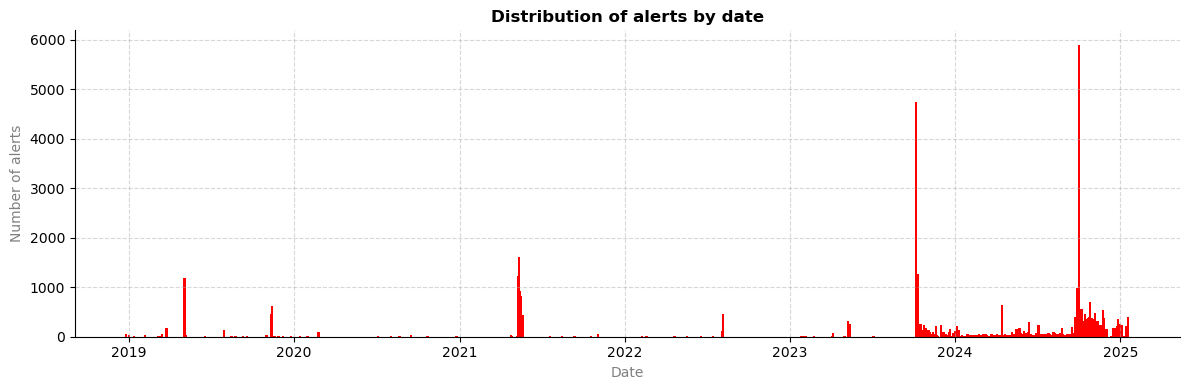

In [8]:
# Grouping by date
alerts_by_date = detailed_df['date'].value_counts().sort_index()

# Plotting the histogram
plt.figure(figsize=(12, 4))
plt.bar(alerts_by_date.index, alerts_by_date.values, color='red', width=5, alpha=1)
plt.xlabel("Date", color='gray')
plt.ylabel("Number of alerts", color='gray')
plt.title("Distribution of alerts by date", fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='both', linestyle='--', alpha=0.5)

# Display the plot
sns.despine()
plt.tight_layout()
plt.show()


### Annual Red Alerts Count

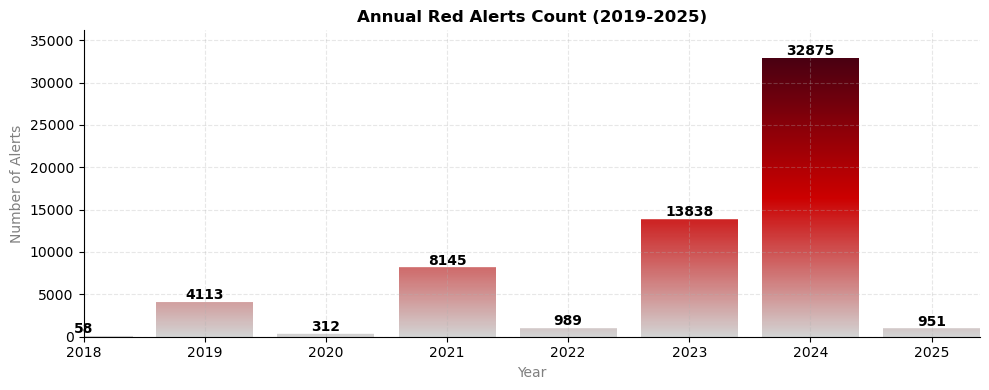

In [9]:
# 1) Define a global gradient from gray (#999999) to burgundy (#4A0012)
base_colors = ["#D3D3D3", "#CC0000", "#4A0012"]
cmap = LinearSegmentedColormap.from_list("gray-to-burgundy", base_colors)

# 2) Determine the maximum value in the dataset (the tallest bar)
max_height = alerts_by_year.values.max()

# 3) Create a vertical array [0..1] that will be stretched along the Y-axis
N = 256
vertical = np.linspace(0, 1, N).reshape(N, 1)  # shape is (256,1)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 4))
bar_width = 0.8

# Iterate over each category (year) and its corresponding value (alerts)
for i, (year, value) in enumerate(zip(alerts_by_year.index, alerts_by_year.values)):
    # Compute the left/right edges for this bar
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    #   alpha=1 from y=0 up to the bar's height
    #   alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)      # number in [0..1]
        y_position = fraction * max_height
        if y_position > value:
            alpha_mask[row] = 0.0

    # Draw an "image" that covers [0..max_height] with our gradient
    ax.imshow(
        vertical,
        origin='lower',      # 0 at the bottom, 1 at the top
        cmap=cmap,           # use our gray->burgundy colormap
        extent=(left, right, 0, max_height),
        aspect='auto',
        alpha=alpha_mask     # make areas above the bar's height transparent
    )

    # Place a label on top of the bar
    # Use smaller, bold font
    ax.text(
        i, value,
        str(int(value)),
        ha='center', 
        va='bottom',
        fontsize=10,         # smaller font size
        fontweight='bold'
    )

# Configure the X-axis to place ticks at the center of each bar
ax.set_xticks(range(len(alerts_by_year)))
ax.set_xticklabels(alerts_by_year.index, rotation=0)

# Extend Y-axis slightly above the tallest bar
ax.set_ylim(0, max_height * 1.1)

# Draw a horizontal dashed grid with moderate opacity
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Draw a vertical dashed grid for columns (lower opacity)
ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Label the axes and set a title
ax.set_xlabel("Year", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Annual Red Alerts Count (2019-2025)", 
             fontweight='bold')

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Auto-adjust layout to prevent label overlap
plt.tight_layout()
plt.show()


- The **number of alerts** has shown significant fluctuations over the years, with a dramatic increase in **2023 and 2024**.  
- **2024 recorded the highest number of alerts (32,875)**, marking an unprecedented escalation in hostilities.  
- The **sharp rise in 2023 (12,970 alerts)** indicates an increasing trend leading up to 2024, likely influenced by the **October 7 war** and subsequent conflicts.  
- **Prior to 2023,** the alert frequency remained relatively lower, with spikes in **2019 (4,113 alerts) and 2021 (8,145 alerts)**, corresponding to specific escalations.  
- The **early data from 2025 (951 alerts)** suggests a **potential de-escalation**, but it is too early to determine if this trend will continue.  


### Number of Red Alerts Per Month

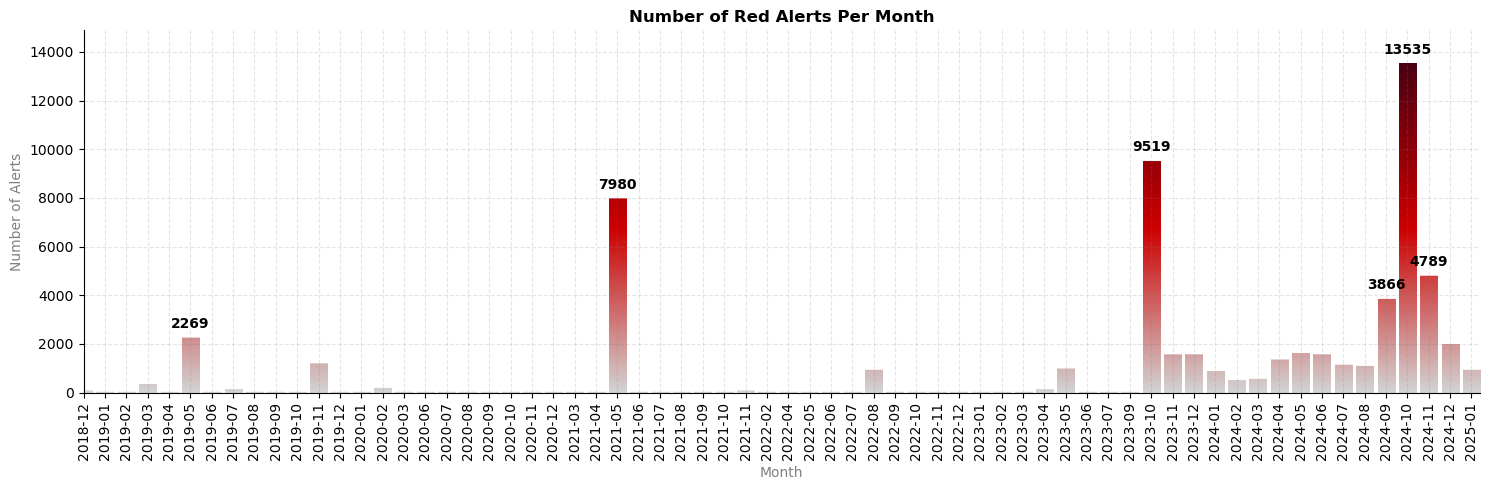

In [10]:
plt.figure(figsize=(15, 5))

# 1) Determine the global maximum alert count
max_alerts = alerts_by_month.values.max()

bar_width = 0.8
ax = plt.gca()

# 3) Plot each bar as a clipped section of the global gradient
for i, (month, value) in enumerate(zip(alerts_by_month.index, alerts_by_month.values)):
    left = i - bar_width / 2
    right = i + bar_width / 2
    
    # Build an alpha mask to hide everything above the bar's actual height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)
        y_pos = fraction * max_alerts
        if y_pos > value:
            alpha_mask[row] = 0.0
    
    ax.imshow(
        vertical,
        origin='lower',
        cmap=cmap,         # global gray->burgundy colormap
        extent=(left, right, 0, max_alerts),
        aspect='auto',
        alpha=alpha_mask
    )
    
    # Label only if above a certain threshold (optional)
    if value > 2000:
        ax.text(
            i,
            value + 0.02 * max_alerts,
            f"{int(value)}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='black'
        )

# 4) Configure X-axis for month labels
ax.set_xticks(range(len(alerts_by_month)))
ax.set_xticklabels(alerts_by_month.index, rotation=90)

# 5) Extend the Y-axis slightly above the tallest bar
ax.set_ylim(0, max_alerts * 1.1)

# 6) Make both horizontal and vertical grid lines dashed and faint
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', alpha=0.2, color='gray')
ax.xaxis.grid(True, linestyle='--', alpha=0.2, color='gray')

# 7) Label axes and set a title
ax.set_xlabel("Month", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Number of Red Alerts Per Month", 
             fontweight='bold')

# 8) Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


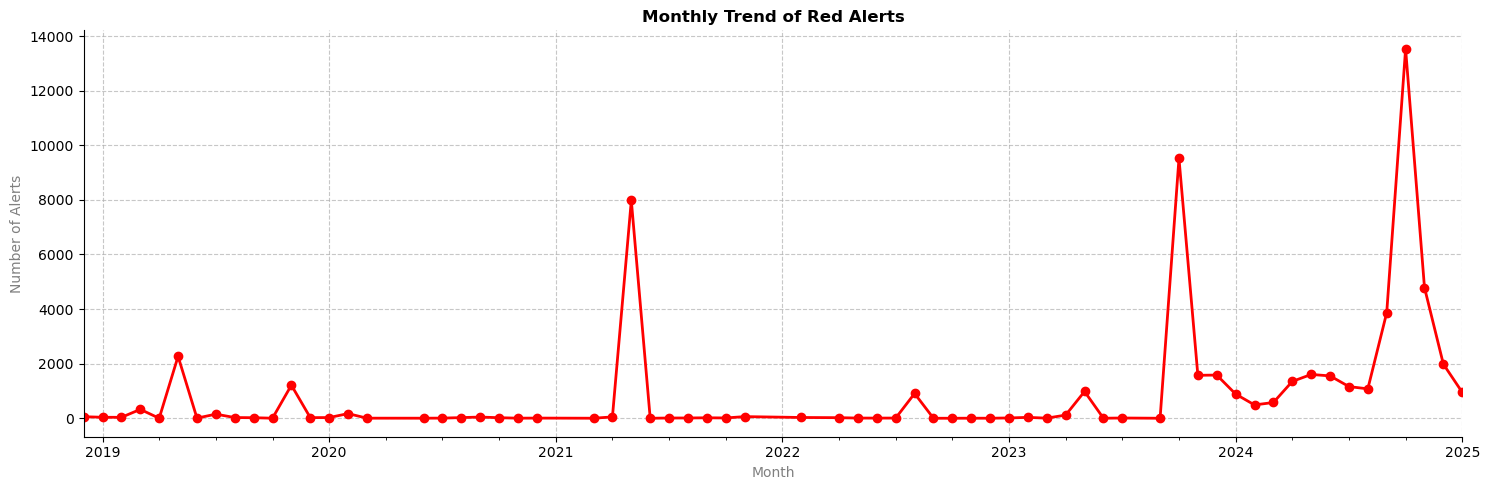

In [11]:
# Plot monthly alerts trend
plt.figure(figsize=(15, 5))
alerts_by_month.plot(kind='line', marker='o', color='red', linewidth=2)
plt.xlabel("Month", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Monthly Trend of Red Alerts", fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()


The highest number of red alerts occurred within a **single month** during major escalations. In cases of **prolonged conflicts**, the **first month** typically had the most alerts, followed by a gradual decline or sustained high activity over time. This pattern is evident in **May 2021 (7,980 alerts)**, **October 2023 (9,519 alerts)**, and **October 2024 (13,535 alerts)**, each marking the peak of respective conflict periods.


- In **2021**, almost all red alerts were concentrated in **May**, indicating a short but intense period of conflict.  
- In **October 2023 and 2024**, the number of alerts was significantly higher, but **more evenly distributed** over time, suggesting prolonged escalations rather than a single peak month.  
- The **2024 peak in October** stands out as the highest alert count, but alerts continued at a relatively high level in the following months, indicating an extended period of hostilities.

### Number of Red Alerts Per Week

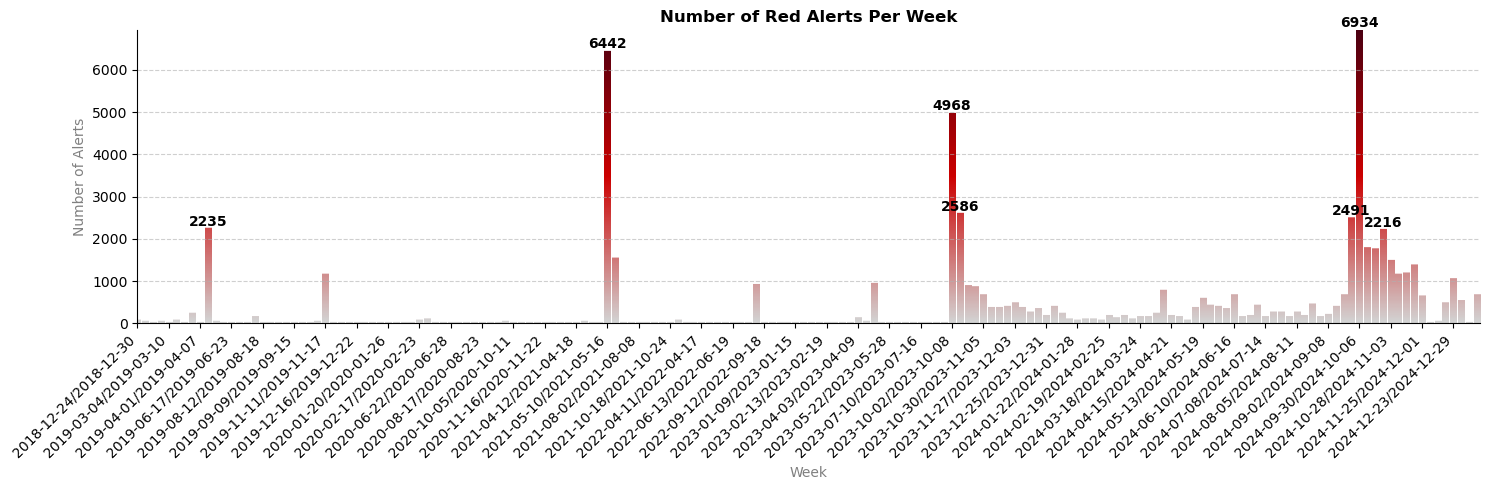

In [12]:
# Set up the figure and axis for the weekly plot
fig, ax = plt.subplots(figsize=(15, 5))

# Determine the maximum value in the weekly dataset
max_week = alerts_by_week.values.max()
bar_width = 0.8  # Width of each bar

# Iterate over each week and its corresponding alert value
for i, (week, value) in enumerate(zip(alerts_by_week.index, alerts_by_week.values)):
    # Compute left/right edges of the bar
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    #   alpha=1 from y=0 up to the bar's height,
    #   alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)  # value in [0, 1]
        y_position = fraction * max_week
        if y_position > value:
            alpha_mask[row] = 0.0

    # Draw the gradient image for this bar using the global colormap
    ax.imshow(
        vertical,
        origin='lower',
        cmap=cmap,
        extent=(left, right, 0, max_week),
        aspect='auto',
        alpha=alpha_mask
    )

    # Annotate the bar only if the value exceeds 2000
    if value > 2000:
        ax.text(i, value, str(int(value)),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

# Configure the X-axis to display every 4th week label to avoid overlap
ax.set_xticks(range(0, len(alerts_by_week), 4))
ax.set_xticklabels(alerts_by_week.index[::4], rotation=45, ha='right')

# Set axis labels and title
ax.set_xlabel("Week", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Number of Red Alerts Per Week", fontweight='bold')

# Add horizontal dashed grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Remove unnecessary spines and grid lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(False)  # Remove vertical grid lines

plt.tight_layout()
plt.show()


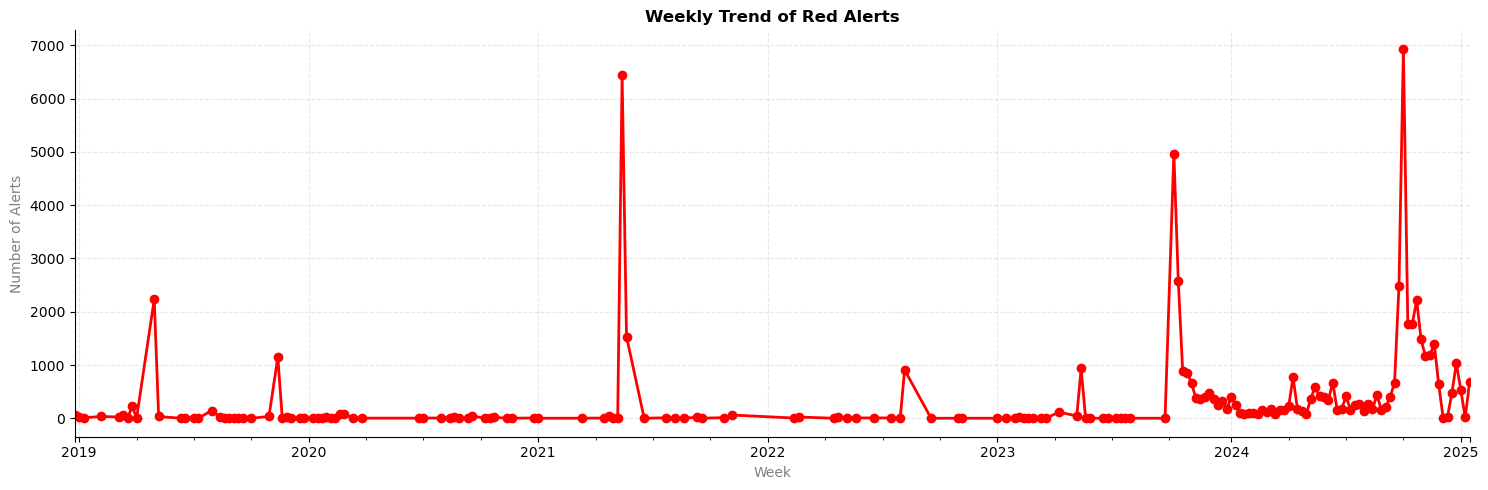

In [13]:
# Plot weekly alerts trend
plt.figure(figsize=(15, 5))
alerts_by_week.plot(kind='line', marker='o', color='red', linewidth=2)
plt.xlabel("Week", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Weekly Trend of Red Alerts", fontweight='bold')
plt.grid(axis='both', linestyle='--', alpha=0.3)
plt.xticks(rotation=0)
sns.despine()
plt.tight_layout()
plt.show()


The **highest intensity of red alerts typically occurs within a single week** during major escalations. The most significant peaks are:  

- **May 2021:** 6,442 alerts in one week  
- **October 2023:** 4,968 alerts in one week  
- **October 2024:** 6,934 alerts in one week (highest recordal peak.

### Red Alerts Distribution by Date

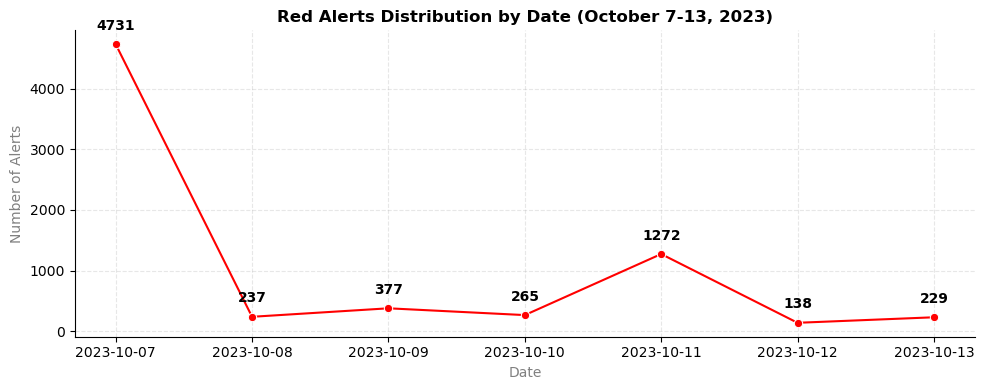

In [14]:
# Filter data from October 7 to October 13, 2023

war_week_end = pd.Timestamp("2023-10-13")

df_war_week = detailed_df[
    (detailed_df['date'] >= war_start.date()) & (detailed_df['date'] <= war_week_end.date())
]

# Group data by date and count alerts
alerts_by_weekday = df_war_week['date'].value_counts().sort_index()


# Convert index to datetime format (if it's not already)
#alerts_by_weekday.index = pd.to_datetime(alerts_by_weekday.index)

# Create the plot
plt.figure(figsize=(10, 4))
ax = sns.lineplot(x=alerts_by_weekday.index, 
                  y=alerts_by_weekday.values, 
                  marker="o", color="red")

# Add labels for each point, placing numbers higher
for x, y in zip(alerts_by_weekday.index, alerts_by_weekday.values):
    plt.text(x, y + max(alerts_by_weekday.values) * 0.05, str(y), 
             ha='center', fontsize=10, fontweight='bold', color='black')

# Labels and title
plt.xlabel("Date", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Red Alerts Distribution by Date (October 7-13, 2023)", 
          fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Show grid for better readability
plt.grid(axis='both', linestyle='--', alpha=0.3)

# Show the plot
# Improve layout aesthetics
sns.despine()
plt.tight_layout()
plt.show()


The first week of the war (October 7–13, 2023) saw a total of **7,249 Red Alerts**. The majority of the alerts (**4,731**) occurred on **October 7**, indicating the intensity of the initial attacks. In the following days, the number of alerts significantly decreased, with **237 on October 8**, **377 on October 9**, **265 on October 10**, and a temporary spike to **1,272 on October 11**. The last two days of the week recorded **138 (October 12)** and **229 (October 13)** alerts, showing a fluctuating but overall declining trend.

On the first day of the conflict, there was a maximum number of attacks, then they decreased. Was it the same in previous escalations?

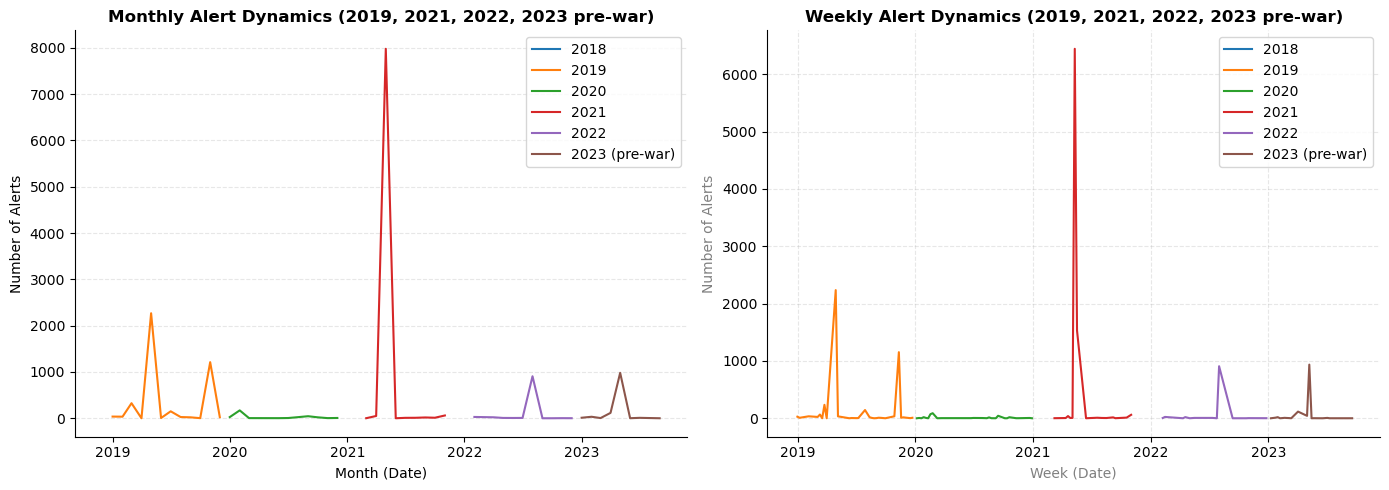

In [15]:
SELECTED_YEARS = [2018, 2019, 2020, 2021, 2022, 2023]

# Filter data for selected years, creating copies to avoid modifying the original DataFrame
filtered_dfs = {
    year: detailed_df[
        (detailed_df['year'] == year) & 
        (detailed_df['datetime'] < war_start if year == 2023 else True)
    ].copy()  # Create a copy to prevent modifications to detailed_df
    for year in SELECTED_YEARS
}

# Function to aggregate alerts by a given time period
def aggregate_alerts(data, period):
    grouped_df = data.groupby(period)['datetime'].count().reset_index(name='count')
    grouped_df[f"{period}_date"] = grouped_df[period].dt.to_timestamp()
    return grouped_df

# Aggregate data by month and week for each year
monthly_data = {year: aggregate_alerts(df, 'month') for year, df in filtered_dfs.items()}
weekly_data  = {year: aggregate_alerts(df, 'week')  for year, df in filtered_dfs.items()}

# Create a figure with two subplots (Monthly & Weekly alert dynamics)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Monthly Alert Dynamics
for year, monthly_df in monthly_data.items():
    label = f"{year} (pre-war)" if year == 2023 else str(year)
    sns.lineplot(data=monthly_df, x="month_date", y="count", 
                 ax=axes[0], label=label)

axes[0].set_title("Monthly Alert Dynamics (2019, 2021, 2022, 2023 pre-war)", 
                  fontsize=12, fontweight="bold")
axes[0].set_xlabel("Month (Date)", fontsize=10)
axes[0].set_ylabel("Number of Alerts", fontsize=10)
axes[0].grid(axis="y", linestyle="--", alpha=0.3)
axes[0].legend()

# Plot Weekly Alert Dynamics
for year, weekly_df in weekly_data.items():
    label = f"{year} (pre-war)" if year == 2023 else str(year)
    sns.lineplot(data=weekly_df, x="week_date", y="count", 
                 ax=axes[1], label=label)

axes[1].set_title("Weekly Alert Dynamics (2019, 2021, 2022, 2023 pre-war)", 
                  fontweight="bold")
axes[1].set_xlabel("Week (Date)", color='gray')
axes[1].set_ylabel("Number of Alerts", color='gray')
axes[1].grid(axis="both", linestyle="--", alpha=0.3)
axes[1].legend()

# Optimize layout and display the plot
sns.despine()
plt.tight_layout()
plt.show()


In [16]:
# Filter the dataset to include only records before the start of the war
df_before_war = detailed_df[detailed_df['datetime'] < war_start]

# Ensure that a 'date' column exists in the filtered dataframe (if not, create it)
if 'date' not in df_before_war.columns:
    df_before_war['date'] = df_before_war['datetime'].dt.date

# Group data by date and count the number of alerts per day
daily_alerts_before = df_before_war.groupby('date')['datetime'].count()

# Define the threshold: if alerts on a day >= threshold, it's considered a conflict day
threshold = 70

# Create a boolean series: True for conflict days, False otherwise
conflict_flags_before = daily_alerts_before >= threshold

# Initialize an empty list to store conflict periods (start and end dates)
conflict_periods_before = []
current_period = None  # This will hold the current period as [start_date, end_date]

# Iterate through each day in the daily alerts series using .items()
for date, is_conflict in conflict_flags_before.items():
    if is_conflict:
        # Start a new conflict period if there is none active
        if current_period is None:
            current_period = [date, date]
        else:
            # If the current day is consecutive with the last day 
            # in the current period, extend the period
            if (date - current_period[1]).days == 1:
                current_period[1] = date
            else:
                # If there's a gap, close the current period and start a new one
                conflict_periods_before.append(tuple(current_period))
                current_period = [date, date]
    else:
        # If it's not a conflict day and we are within a conflict period, close that period
        if current_period is not None:
            conflict_periods_before.append(tuple(current_period))
            current_period = None

# If the last days were part of an active conflict period, add it to the list
if current_period is not None:
    conflict_periods_before.append(tuple(current_period))

# Display the detected conflict periods before the war
print("Detected conflict periods before war start (days with >= 70 alerts):")
for start, end in conflict_periods_before:
    duration = (end - start).days + 1  # +1 to include both start and end days
    print(f"From {start} to {end} (Duration: {duration} days)")


Detected conflict periods before war start (days with >= 70 alerts):
From 2019-03-25 to 2019-03-25 (Duration: 1 days)
From 2019-05-04 to 2019-05-05 (Duration: 2 days)
From 2019-07-31 to 2019-07-31 (Duration: 1 days)
From 2019-11-12 to 2019-11-14 (Duration: 3 days)
From 2020-02-23 to 2020-02-24 (Duration: 2 days)
From 2021-05-10 to 2021-05-20 (Duration: 11 days)
From 2022-08-05 to 2022-08-07 (Duration: 3 days)
From 2023-04-06 to 2023-04-06 (Duration: 1 days)
From 2023-05-10 to 2023-05-13 (Duration: 4 days)


Let's check for conflicts that lasted longer than 2 days.

In [17]:
# Define conflict periods for escalations in 2019, 2021, 2022, and 2023.
# Replace the dates below with the actual conflict start and end dates.
conflict_periods = {
    2019: {'start': pd.Timestamp("2019-05-04"), 'end': pd.Timestamp("2019-05-05")},
    2019: {'start': pd.Timestamp("2019-11-12"), 'end': pd.Timestamp("2019-11-14")},
    2021: {'start': pd.Timestamp("2021-05-10"), 'end': pd.Timestamp("2021-05-20")},
    2022: {'start': pd.Timestamp("2022-08-05"), 'end': pd.Timestamp("2022-08-07")},
    2023: {'start': pd.Timestamp("2023-05-10"), 'end': pd.Timestamp("2023-05-13")}
}

# Loop through each conflict period to analyze daily alert counts
for year, period in conflict_periods.items():
    conflict_start = period['start']
    conflict_end = period['end']
    
    # Filter data for the conflict period
    df_conflict = detailed_df[(detailed_df['datetime'] >= conflict_start) & 
                              (detailed_df['datetime'] <= conflict_end)].copy()
    
    # Ensure there's a 'date' column (extracted from 'datetime') for grouping by day
    df_conflict['date'] = df_conflict['datetime'].dt.date
    
    # Group the data by date and count the alerts per day
    daily_alerts = df_conflict.groupby('date')['datetime'].count()
    
    # Determine the maximum alert count and the corresponding date
    max_alerts = daily_alerts.max()
    max_alert_date = daily_alerts.idxmax()
    
    # Get the alert count on the first day of the conflict
    first_day = conflict_start.date()
    first_day_alerts = daily_alerts.get(first_day, 0)
    
    # Check if the maximum number of alerts occurred on the first day
    if first_day_alerts == max_alerts:
        print(f"In {year}, maximum alerts ({max_alerts}) occurred on the first day ({first_day}).")
    else:
        print(f"In {year}, maximum alerts did NOT occur on the first day.")
        print(f"Alerts on the first day ({first_day}): {first_day_alerts}, "
              f"Maximum alerts on {max_alert_date}: {max_alerts}")
        print('–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––')


In 2019, maximum alerts did NOT occur on the first day.
Alerts on the first day (2019-11-12): 454, Maximum alerts on 2019-11-13: 622
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
In 2021, maximum alerts did NOT occur on the first day.
Alerts on the first day (2021-05-10): 237, Maximum alerts on 2021-05-12: 1606
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
In 2022, maximum alerts did NOT occur on the first day.
Alerts on the first day (2022-08-05): 111, Maximum alerts on 2022-08-06: 339
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
In 2023, maximum alerts (318) occurred on the first day (2023-05-10).


The pattern observed in the **first week of the 2023 war**, where the highest number of Red Alerts occurred on the **first day (October 7)** followed by a decline, was **not consistent in previous escalations**.

- In **2019, 2021, and 2022**, the **peak of alerts occurred after the first day**, suggesting a buildup in intensity rather than an immediate peak.
- In **2023 (May escalation)**, however, the **first day had the maximum number of alerts**, resembling the pattern seen in October 2023.


### Top-10 days with the Highest Number of Alerts

In [18]:
# Group data by date and count the number of alerts per day
daily_alerts = detailed_df.groupby('date')['datetime'].count()

# Get the top 10 days with the highest number of alerts
top_10_days = daily_alerts.nlargest(10).reset_index()

# Rename columns for better readability
top_10_days.columns = ['Date', 'Number of Alerts']

# Display the result
print("Top 10 Days with the Highest Number of Alerts:")
top_10_days


Top 10 Days with the Highest Number of Alerts:


,Date,Number of Alerts
0,2024-10-01,5891
1,2023-10-07,4731
2,2021-05-12,1606
3,2023-10-11,1272
4,2021-05-11,1226
5,2019-05-04,1180
6,2019-05-05,1051
7,2024-09-28,976
8,2021-05-13,962
9,2021-05-15,925


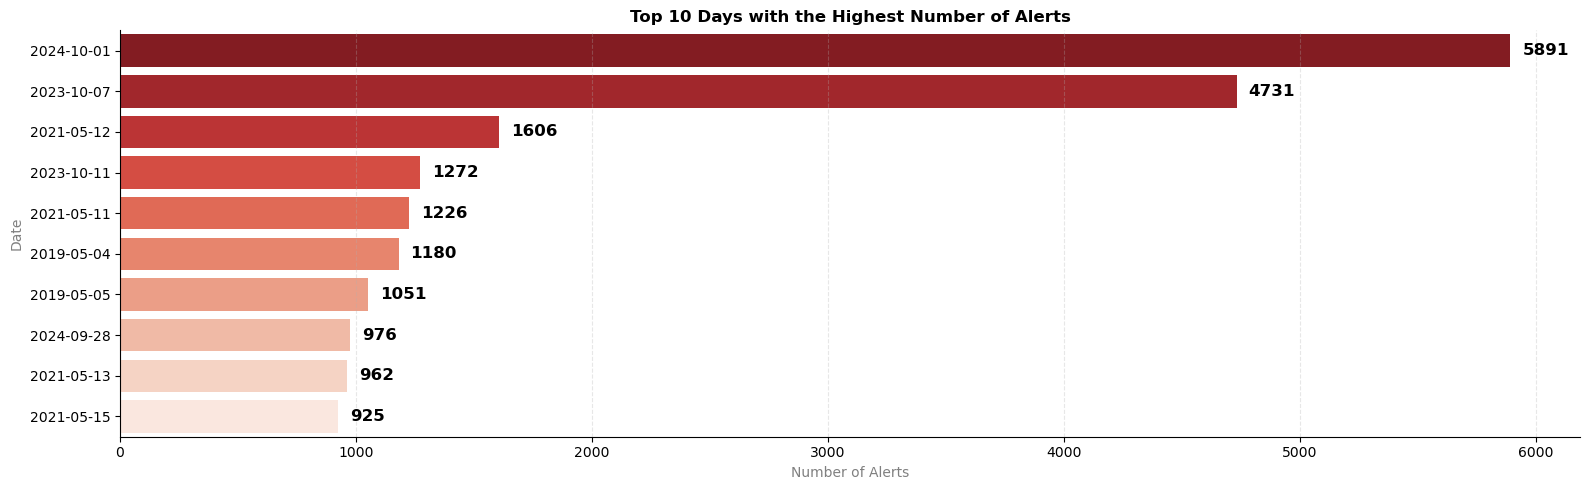

In [19]:
# Create figure
plt.figure(figsize=(16, 5))

# Create horizontal barplot
ax = sns.barplot(
    data=top_10_days, 
    y="Date", 
    x="Number of Alerts", 
    hue="Date",  # Assign hue to y-variable to use palette
    palette="Reds_r", 
    legend=False,  # Disable legend since it's redundant
    orient="h"
)

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_width())}',  # Convert number of alerts to int for clarity
        (p.get_width() + 50, p.get_y() + p.get_height() / 2),  
        ha='left', va='center', 
        fontsize=12, fontweight='bold', color='black'
    )

# Add titles and labels
plt.title("Top 10 Days with the Highest Number of Alerts", 
          fontweight="bold")
plt.xlabel("Number of Alerts", color='gray')
plt.ylabel("Date", color='gray')
plt.grid(axis="x", linestyle="--", alpha=0.3)

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()


The **highest peak occurred on October 1, 2024**, with **5,891 alerts**, corresponding to the **Iranian attack**.  The **next most intense day was October 7, 2023**, with **4,731 alerts**, marking the **Hamas attack on Israel**.

Another major escalation happened in **May 2021**, with **1,606 alerts on May 12**, during the **Gaza conflict**. These spikes show that conflict outbreaks can escalate rapidly, leading to extreme surges in alerts within short time frames, significantly impacting regional security. 🚨

---

### Conclusion

📊 **Key Findings**  

- **Total Alerts:** 61,281
- **Before October 7, 2023:** 14,779 alerts (24.12%) 
- **After October 7, 2023:** 46,502 alerts (75.88%)  
- **Peak Alert Year:** 2024, with 32,875 alerts, surpassing all previous years.
- The **highest peak occurred on October 1, 2024**, with **5,891 alerts** during the **Iranian attack**, followed by **October 7, 2023**, with **4,731 alerts** during the **Hamas attack on Israel**, while **May 12, 2021**, saw **1,606 alerts** amid the **Gaza conflict**, highlighting the rapid escalation of conflicts and their significant impact on regional security. 🚨

---

**Annual Trends**  

- Red alerts increased sharply in **2021 (8,145 alerts)**, followed by a decline in **2022 (989 alerts)**.  
- **2023 saw a dramatic rise (13,838 alerts)**, but **2024 reached an unprecedented peak (32,875 alerts)**, indicating a major escalation.  
- In **early 2025**, alerts have significantly declined (951 so far), but it is difficult to do conclusions, since the year has only just begun.

**Monthly Trends**  

- Three **major peaks** in the dataset:  **May 2021 (7,980 alerts)**, **October 2023 (9,519 alerts)**, **October 2024 (13,535 alerts)**  
- After October 7, 2023, alerts continued at a high rate, with **multiple months exceeding 3,000 alerts**.  

**Weekly Trends**  

- The **highest weekly alert count** occurred in **October 2024 (6,934 alerts)**, surpassing the **May 2021 peak (6,442 alerts)**.  
- **October 2023 saw 4,968 alerts in a single week**, highlighting another significant escalation. The majority of the alerts (**4,731**) occurred on **October 7**, the first day of the war.

---

**🔍 Key Insights**  

- **October 7, 2023, marks a turning point**, with **over 75% of all alerts occurring after this date**.  
- The data shows a **shift from short, intense conflicts (e.g., May 2021) to prolonged, high-frequency alert periods (October 2023-2024).**  
- **2024 represents the most sustained period of alerts**, with **no significant reduction until 2025**.  
- While **some escalations begin with an initial peak**, others **escalate over time**, highlighting differences in conflict dynamics across different years.

## ⏰ Analysis of Alert Timing and Weekly Patterns
### By Hour of the Day

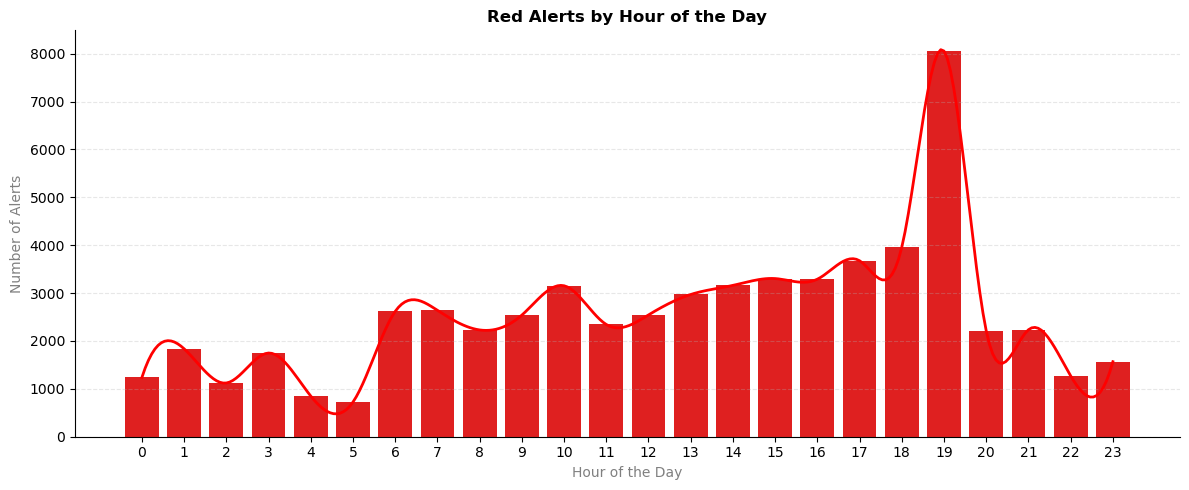

In [20]:
# Alerts by hour of the day
alerts_by_hour = detailed_df['hour'].value_counts().sort_index()

# Create smooth curve
x = alerts_by_hour.index  
y = alerts_by_hour.values  

# Generating a smoothed line
x_smooth = np.linspace(x.min(), x.max(), 300) 
spline = make_interp_spline(x, y, k=3) 
y_smooth = spline(x_smooth)

# Plot the distribution of alerts by hour
plt.figure(figsize=(12, 5))

# Bar plot
sns.barplot(x=x, y=y, color="red")

# Smooth line plot
plt.plot(x_smooth, y_smooth, color="red", linewidth=2)

plt.xlabel("Hour of the Day", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Red Alerts by Hour of the Day", fontweight='bold')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()


- **Peak hours:** The highest number of alerts occurs around **19:00-20:00**, showing a **significant spike**.
- **Gradual increase:** Alerts steadily rise from early morning, with a **notable increase after 06:00**.
- **Evening escalation:** A **sharp rise begins in the late afternoon**, peaking in the evening.
- **Nighttime decrease:** Alerts drop significantly after **20:00**, but still remain **higher than early morning levels**.
- **Lowest activity:** The fewest alerts occur around **05:00-06:00**, suggesting a **lower risk window** during the early morning hours.

---

🔍 **Key Insight:** 

The **evening peak** suggests a **tactical preference** for attacks during specific hours, possibly aiming for **maximum impact** or leveraging strategic conditions. The **early morning dip** may indicate a period of relative calm, likely due to operational or environmental factors.
itions.


### Distribution by Minute

Alerts within ±5 minutes of the hour: 14476 (23.62%)
Alerts within ±5 minutes of the half-hour: 11459 (18.70%)
Alerts within 0-5 minutes: 9885 (16.13%)
Alerts within 30-35 minutes: 7472 (12.19%)


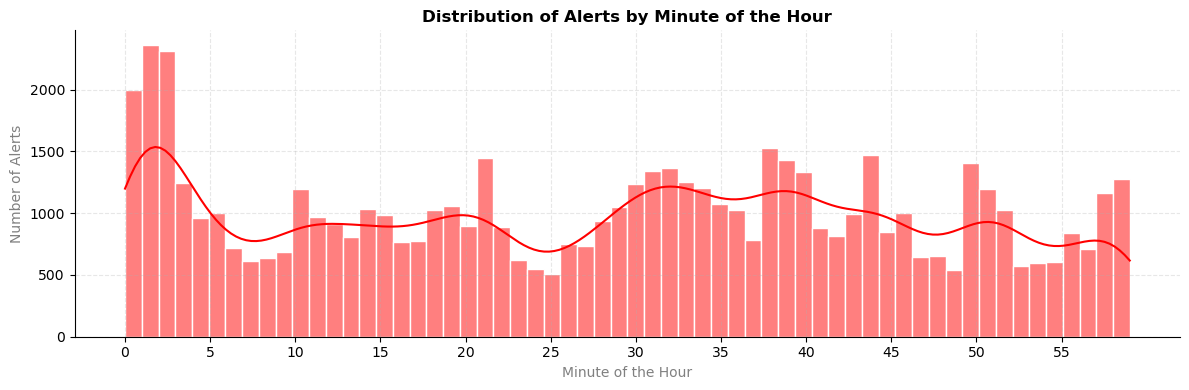

In [21]:
# Extract time components
#detailed_df['hour'] = detailed_df['datetime'].dt.hour
detailed_df['minute'] = detailed_df['datetime'].dt.minute
detailed_df['weekday'] = detailed_df['datetime'].dt.dayofweek  # Monday = 0, Sunday = 6

# Count alerts within ±5 minutes of the hour (00)
alerts_near_00 = detailed_df[(detailed_df['minute'] >= 55) | (detailed_df['minute'] <= 5)].shape[0]

# Count alerts within ±5 minutes of the half-hour (30)
alerts_near_30 = detailed_df[(detailed_df['minute'] >= 25) & (detailed_df['minute'] <= 35)].shape[0]

# Total alerts
total_alerts = detailed_df.shape[0]

# Calculate percentages
percentage_near_00 = (alerts_near_00 / total_alerts) * 100
percentage_near_30 = (alerts_near_30 / total_alerts) * 100

# Display results
print(f"Alerts within ±5 minutes of the hour: {alerts_near_00} ({percentage_near_00:.2f}%)")
print(f"Alerts within ±5 minutes of the half-hour: {alerts_near_30} ({percentage_near_30:.2f}%)")


# Count alerts within 0-5 minutes
alerts_0_5 = detailed_df[(detailed_df['minute'] >= 0) & (detailed_df['minute'] <= 5)].shape[0]

# Count alerts within 30-35 minutes
alerts_30_35 = detailed_df[(detailed_df['minute'] >= 30) & (detailed_df['minute'] <= 35)].shape[0]


# Calculate percentages
percentage_0_5 = (alerts_0_5 / total_alerts) * 100
percentage_30_35 = (alerts_30_35 / total_alerts) * 100

# Display results
print(f"Alerts within 0-5 minutes: {alerts_0_5} ({percentage_0_5:.2f}%)")
print(f"Alerts within 30-35 minutes: {alerts_30_35} ({percentage_30_35:.2f}%)")


# Plot the distribution of alerts by minute
plt.figure(figsize=(12, 4))
sns.histplot(detailed_df['minute'], bins=60, kde=True, color="red",  edgecolor="white")
plt.xlabel("Minute of the Hour", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Distribution of Alerts by Minute of the Hour", fontweight='bold')
plt.xticks(range(0, 60, 5))
plt.grid(axis='both', linestyle='--', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()


- A significant **peak in alerts** occurs at the beginning of each hour, particularly within the first five minutes. 
- Another noticeable increase happens around the **30th minute** of the hour.
- Alerts tend to be less frequent in the middle of each half-hour segment.
- **23.62% of all alerts** occur within **±5 minutes** of the hour mark. **18.70% of all alerts** happen within **±5 minutes** of the half-hour mark.

These findings suggest that alert activity is **not evenly distributed** and tends to cluster around specific time intervals, likely influenced by scheduled or periodic triggers.

---

**Analyzing Attack Patterns of Key Groups**

The primary groups involved in the conflict are **Hamas** and **Hezbollah**. This analysis aims to determine whether these groups exhibit **distinct preferences in terms of attack timing** based on available data.



**Dataset Segmentation Approach**

Since the dataset includes attacks from **Iran, Yemen, Iraq, and Syria**, directly tagging each attack to a specific source is not straightforward. To simplify the analysis, we categorize the dataset based on time periods and known patterns of activity:

**1. Hamas Attacks:**  
- Hamas' attacks are defined as:
  - **All attacks before May 1, 2024**, excluding those attributed to Hezbollah.
  - **All attacks in the 'Southern District' until September 2024** (after which Hamas' activity becomes less distinct in the dataset).

**2. Hezbollah Attacks:**  
- Hezbollah's attacks are defined as:
  - **All attacks from October 8, 2023, onward** in the **'Northern District' and 'Haifa District'**.
  - **All attacks in all regions starting from October 20, 2024**.

**3. Excluding Iranian Attacks:**  
To avoid misattributions, **Iranian attacks are excluded**, specifically:
  - **October 1, 2024, from 19:00 to 20:00.**
  - **April 14, 2024, from 01:00 to 04:00.**


This segmentation provides a structured approach to identifying **patterns in attack timing** for both Hamas and Hezbollah while mitigating distortions from other sources in the dataset.

Alerts within ±5 minutes of the hour: 11230 (27.15%)
Alerts within ±5 minutes of the half-hour: 7396 (17.88%)
Alerts within 0-5 minutes: 7491 (18.11%)
Alerts within 30-35 minutes: 4851 (11.73%)


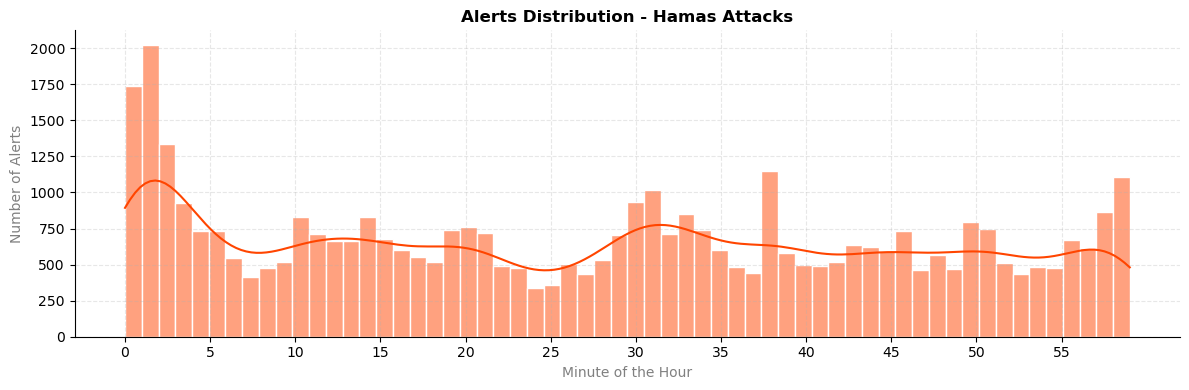

In [22]:
# Define specific attack periods by Iran (to be excluded)
iran_attack_periods = [
    (pd.Timestamp('2024-10-01 19:00:00'), pd.Timestamp('2024-10-01 20:00:00')),
    (pd.Timestamp('2024-04-14 01:00:00'), pd.Timestamp('2024-04-14 04:00:00'))
]

# Define Hezbollah attack periods and areas
hezbollah_start = pd.Timestamp('2023-10-08')
hezbollah_expansion = pd.Timestamp('2024-10-20')
hezbollah_districts = ['Northern District', 'Haifa District']

# Define Hamas attack cutoff and districts
hamas_cutoff = pd.Timestamp('2024-05-01')
hamas_districts = ['Southern District']


# Filtering Hezbollah Attacks
hezbollah_attacks = detailed_df[
    ((detailed_df['datetime'] >= hezbollah_start) & (detailed_df['district'].isin(hezbollah_districts))) |
    (detailed_df['datetime'] >= hezbollah_expansion)
]

# Exclude Iranian attack periods
for start, end in iran_attack_periods:
    hezbollah_attacks = hezbollah_attacks[
        ~((hezbollah_attacks['datetime'] >= start) & (hezbollah_attacks['datetime'] < end))
    ]


# Filtering Hamas Attacks
hamas_attacks = detailed_df[
    ((detailed_df['datetime'] < hamas_cutoff) & ~detailed_df['district'].isin(hezbollah_districts)) |
    ((detailed_df['datetime'] >= hamas_cutoff) & (detailed_df['district'].isin(hamas_districts)))
]


# Total number of Hamas alerts
hamas_total_alerts = hamas_attacks.shape[0]

# --- Alerts within ±5 minutes of the hour (00) ---
condition_near_00 = (hamas_attacks['minute'] >= 55) | (hamas_attacks['minute'] <= 5)
hamas_alerts_near_00 = hamas_attacks[condition_near_00].shape[0]
hamas_percentage_near_00 = (hamas_alerts_near_00 / hamas_total_alerts) * 100

# --- Alerts within ±5 minutes of the half-hour (30) ---
condition_near_30 = (hamas_attacks['minute'] >= 25) & (hamas_attacks['minute'] <= 35)
hamas_alerts_near_30 = hamas_attacks[condition_near_30].shape[0]
hamas_percentage_near_30 = (hamas_alerts_near_30 / hamas_total_alerts) * 100


# Alerts within 0-5 minutes
condition_0_5 = (hamas_attacks['minute'] >= 0) & (hamas_attacks['minute'] <= 5)
hamas_alerts_0_5 = hamas_attacks[condition_0_5].shape[0]
hamas_percentage_0_5 = (hamas_alerts_0_5 / hamas_total_alerts) * 100

# Alerts within 30-35 minutes
condition_30_35 = (hamas_attacks['minute'] >= 30) & (hamas_attacks['minute'] <= 35)
hamas_alerts_30_35 = hamas_attacks[condition_30_35].shape[0]
hamas_percentage_30_35 = (hamas_alerts_30_35 / hamas_total_alerts) * 100


print(
    f"Alerts within ±5 minutes of the hour: {hamas_alerts_near_00} "
    f"({hamas_percentage_near_00:.2f}%)"
)
print(
    f"Alerts within ±5 minutes of the half-hour: {hamas_alerts_near_30} "
    f"({hamas_percentage_near_30:.2f}%)"
)
print(
    f"Alerts within 0-5 minutes: {hamas_alerts_0_5} "
    f"({hamas_percentage_0_5:.2f}%)"
)
print(
    f"Alerts within 30-35 minutes: {hamas_alerts_30_35} "
    f"({hamas_percentage_30_35:.2f}%)"
)


plt.figure(figsize=(12, 4))
sns.histplot(
    hamas_attacks['minute'],
    bins=60,
    kde=True,
    color="#FF4500",
    edgecolor="white"
)
plt.xlabel("Minute of the Hour", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Alerts Distribution - Hamas Attacks", fontweight='bold')
plt.xticks(range(0, 60, 5))
plt.grid(axis='both', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


Alerts within ±5 minutes of the hour: 3484 (19.32%)
Alerts within ±5 minutes of the half-hour: 3622 (20.09%)
Alerts within 0-5 minutes: 2610 (14.47%)
Alerts within 30-35 minutes: 1921 (10.65%)


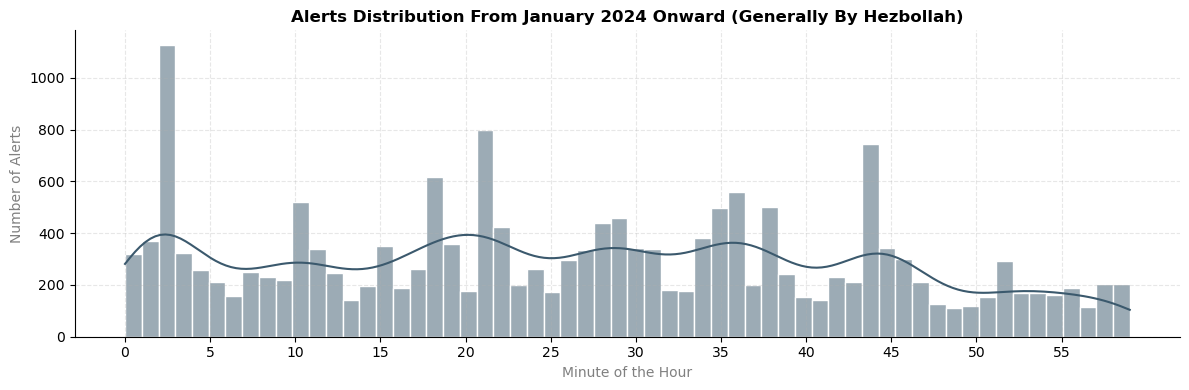

In [23]:
# -----------------------------------------------------------------------------
# Counting the number and percentage of alerts because of Hesbollah based on time intervals
# -----------------------------------------------------------------------------

# Total number of alerts
hezbollah_total_alerts = hezbollah_attacks.shape[0]

# --- Alerts within ±5 minutes of the hour (00) ---
condition_near_00 = (
    (hezbollah_attacks['minute'] >= 55) | (hezbollah_attacks['minute'] <= 5)
)
hezbollah_alerts_near_00 = hezbollah_attacks[condition_near_00].shape[0]
hezbollah_percentage_near_00 = (hezbollah_alerts_near_00 / hezbollah_total_alerts) * 100

# --- Alerts within ±5 minutes of the half-hour (30) ---
condition_near_30 = (
    (hezbollah_attacks['minute'] >= 25) & (hezbollah_attacks['minute'] <= 35)
)
hezbollah_alerts_near_30 = hezbollah_attacks[condition_near_30].shape[0]
hezbollah_percentage_near_30 = (hezbollah_alerts_near_30 / hezbollah_total_alerts) * 100


# Alerts within the 0-5 minute range
condition_0_5 = (hezbollah_attacks['minute'] >= 0) & (hezbollah_attacks['minute'] <= 5)
hezbollah_alerts_0_5 = hezbollah_attacks[condition_0_5].shape[0]
hezbollah_percentage_0_5 = (hezbollah_alerts_0_5 / hezbollah_total_alerts) * 100

# Alerts within the 30-35 minute range
condition_30_35 = (hezbollah_attacks['minute'] >= 30) & (hezbollah_attacks['minute'] <= 35)
hezbollah_alerts_30_35 = hezbollah_attacks[condition_30_35].shape[0]
hezbollah_percentage_30_35 = (hezbollah_alerts_30_35 / hezbollah_total_alerts) * 100


print(
    f"Alerts within ±5 minutes of the hour: {hezbollah_alerts_near_00} "
    f"({hezbollah_percentage_near_00:.2f}%)"
)
print(
    f"Alerts within ±5 minutes of the half-hour: {hezbollah_alerts_near_30} "
    f"({hezbollah_percentage_near_30:.2f}%)"
)
print(
    f"Alerts within 0-5 minutes: {hezbollah_alerts_0_5} "
    f"({hezbollah_percentage_0_5:.2f}%)"
)
print(
    f"Alerts within 30-35 minutes: {hezbollah_alerts_30_35} "
    f"({hezbollah_percentage_30_35:.2f}%)"
)


plt.figure(figsize=(12, 4))
sns.histplot(
    hezbollah_attacks['minute'],
    bins=60,
    kde=True,
    color="#3B596D",
    edgecolor="white"
)
plt.xlabel("Minute of the Hour", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title(
    "Alerts Distribution From January 2024 Onward (Generally By Hezbollah)",
   
    fontweight='bold'
)
plt.xticks(range(0, 60, 5))
plt.grid(axis='both', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

📊 **General Observations**  
- **High Concentration at Key Intervals**: Approximately **42.32%** of all alerts occur within **±5 minutes of the hour**(23.62%) and **±5 minutes of the half-hour**(18.70%). A significant portion of alerts occur **within the first 5 minutes of each hour (16.13%)**.
- **Strategic Timing of Attacks**: The peaks in alert frequency strongly suggest **non-random attack timing**, likely aimed at maximizing disruption or overwhelming defense systems.


📊 **Additional Reasoning:**  
If we divide an hour into 6 segments of 10 minutes each, and if there were no timing preferences, the alerts would be distributed uniformly at **16.6% per segment**. If the percentage of alerts in specific time segments is significantly higher than 16.6%, this strongly suggests that the timing of attacks is not random.
For 5 minute period it will be **8.33% per segment**.

---

**Comparing Hamas and Hezbollah Attack Timing**
⚠ We divided our dataset to identify **attack timing patterns** for key groups: **Hamas attacks** were analyzed using data **before January 2024**, while **Hezbollah attacks** were isolated to the period **from January to November 2024**. Although **Hezbollah began its attacks on October 8, 2023** and the dataset includes attacks from **Iran, Yemen, Iraq, and Syria**, this segmentation focuses on periods when Hamas and Hezbollah were most active.

**1. Hamas Attacks**
- **Clear peak at the hour:** **18.49%** of Hamas alerts occur in the first **0-5 minutes** of the hour, indicating a **strong preference for striking at the start of an hour**.
- **Secondary peak at 30 minutes:** **11.71%** of alerts occur in the **30-35 minute range**, reinforcing a strategic approach.
- **Tactical Considerations:** This pattern may be **intended to create psychological pressure**, anticipating routine shifts or moments of reduced vigilance.

**2. Hezbollah Attacks**
- **Less pronounced concentration:** **14.61%** of alerts occur in the first **0-5 minutes**, lower than Hamas' pattern but still notable.
- **More even distribution:** The **10.76%** of alerts in the **30-35 minute range** indicates a less rigid pattern than Hamas, suggesting more **adaptability in attack timing**.
- **Strategic Difference:** Hezbollah attacks seem **more evenly spread** throughout the hour, reducing predictability compared to Hamas' clear preference for **top-of-the-hour strikes**.

---

🔍 **Key Insight:**  
- **Hamas exhibits a structured attack timing pattern,** **favoring the start of the hour**, potentially aiming to **exploit routine-based vulnerabilities**.
- **Hezbollah follows a more adaptive strategy,** with a **broader spread of attacks** to maintain unpredictability.
- **Overall, nearly 30% of all alerts fall within key time windows (0-5 min & 30-35 min), indicating intentional attack scheduling.** 

These findings suggest that **both Hamas and Hezbollah utilize strategic attack timing, but in distinct ways—Hamas favoring predictability, while Hezbollah appears more varied in its approach.**

### By Day of the Week

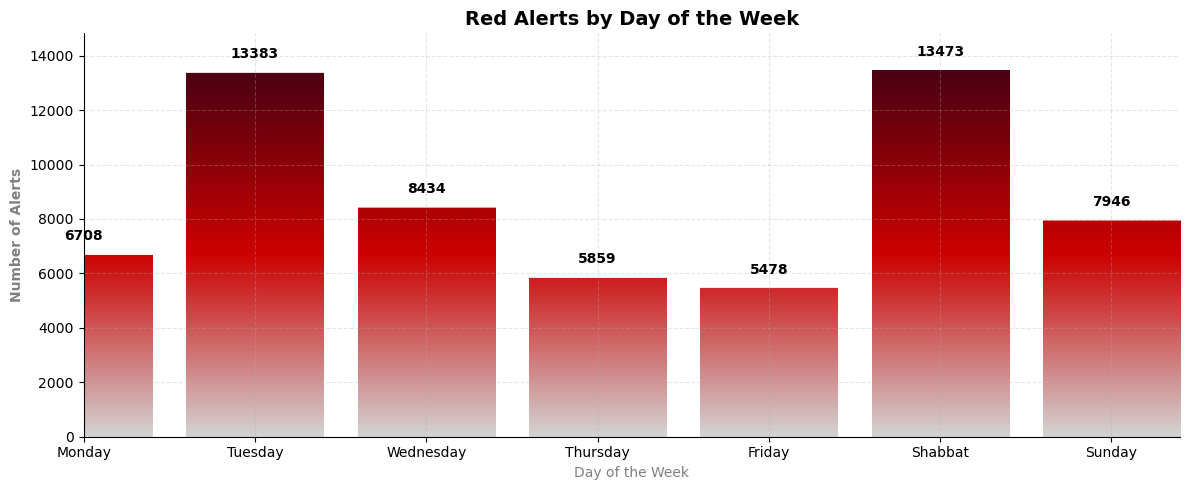

In [24]:
# Count alerts by weekday
alerts_by_weekday = detailed_df['weekday'].value_counts().sort_index()

# Convert numeric weekday to labels
weekday_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Shabbat", "Sunday"]
alerts_by_weekday.index = weekday_labels

# Determine the maximum value in the dataset (tallest bar)
max_height = alerts_by_weekday.values.max()

# Create a vertical array [0..1] stretched along the Y-axis
#N = 256
#vertical = np.linspace(0, 1, N).reshape(N, 1)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 0.8

# Iterate over each category (weekday) and its corresponding value (alerts)
for i, (day, value) in enumerate(zip(alerts_by_weekday.index, alerts_by_weekday.values)):
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    # alpha=1 from y=0 up to the bar's height
    # alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)  # value in range [0..1]
        y_position = fraction * max_height
        if y_position > value:
            alpha_mask[row] = 0.0  # Make areas above the bar height transparent

    # Draw an "image" that covers [0..max_height] with the gradient
    ax.imshow(
        vertical,
        origin='lower',  # 0 at the bottom, 1 at the top
        cmap=cmap,       # use the gray->burgundy colormap
        extent=(left, right, 0, max_height),
        aspect='auto',
        alpha=alpha_mask  # apply transparency above the bar height
    )

    # Place a label on top of the bar
    ax.text(
        i, value + max_height * 0.03,  # Adjusted position for visibility
        str(int(value)),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Configure the X-axis to place ticks at the center of each bar
ax.set_xticks(range(len(alerts_by_weekday)))
ax.set_xticklabels(alerts_by_weekday.index, rotation=0)

# Extend Y-axis slightly above the tallest bar
ax.set_ylim(0, max_height * 1.1)

# Draw a horizontal dashed grid with moderate opacity
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Draw a vertical dashed grid for columns (lower opacity)
ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Label the axes and set a title
ax.set_xlabel("Day of the Week", color='gray')
ax.set_ylabel("Number of Alerts", color='gray',  fontweight='bold')
ax.set_title("Red Alerts by Day of the Week", size=14, fontweight='bold')

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Auto-adjust layout to prevent label overlap
plt.tight_layout()
plt.show()



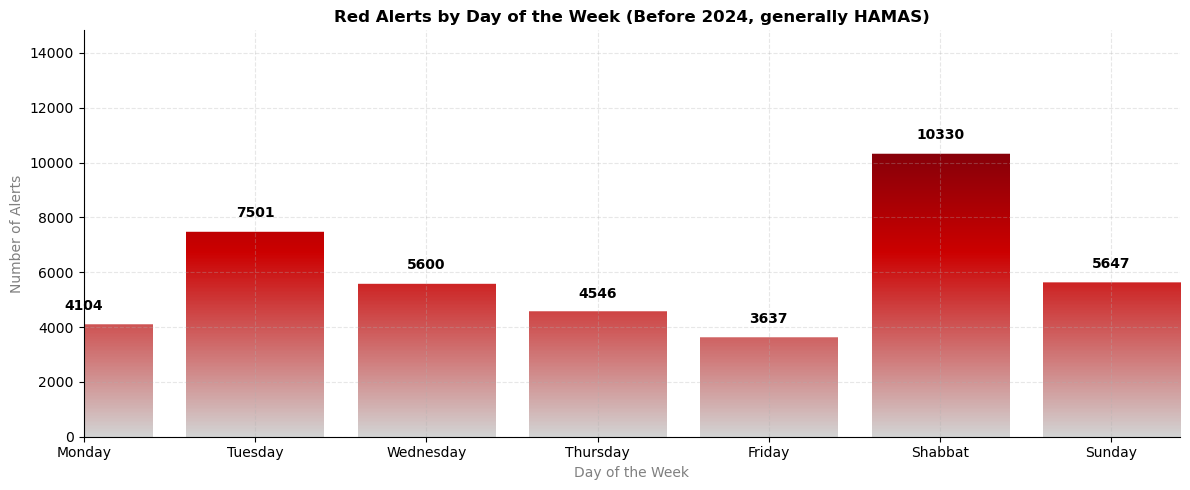

In [25]:
# Count alerts by weekday
alerts_by_weekday_hamas = hamas_attacks['weekday'].value_counts().sort_index()

# Convert numeric weekday to labels
alerts_by_weekday_hamas.index = weekday_labels

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 0.8

# Iterate over each category (weekday) and its corresponding value (alerts)
for i, (day, value) in enumerate(zip(alerts_by_weekday_hamas.index, alerts_by_weekday_hamas.values)):
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    # alpha=1 from y=0 up to the bar's height
    # alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)  # value in range [0..1]
        y_position = fraction * max_height
        if y_position > value:
            alpha_mask[row] = 0.0  # Make areas above the bar height transparent

    # Draw an "image" that covers [0..max_height] with the gradient
    ax.imshow(
        vertical,
        origin='lower',  # 0 at the bottom, 1 at the top
        cmap=cmap,       # use the gray->burgundy colormap
        extent=(left, right, 0, max_height),
        aspect='auto',
        alpha=alpha_mask  # apply transparency above the bar height
    )

    # Place a label on top of the bar
    ax.text(
        i, value + max_height * 0.03,  # Adjusted position for visibility
        str(int(value)),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Configure the X-axis to place ticks at the center of each bar
ax.set_xticks(range(len(alerts_by_weekday_hamas)))
ax.set_xticklabels(alerts_by_weekday_hamas.index, rotation=0)

# Extend Y-axis slightly above the tallest bar
ax.set_ylim(0, max_height * 1.1)

# Draw a horizontal dashed grid with moderate opacity
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Draw a vertical dashed grid for columns (lower opacity)
ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Label the axes and set a title
ax.set_xlabel("Day of the Week", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Red Alerts by Day of the Week (Before 2024, generally HAMAS)", 
             fontweight='bold')

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Auto-adjust layout to prevent label overlap
plt.tight_layout()
plt.show()


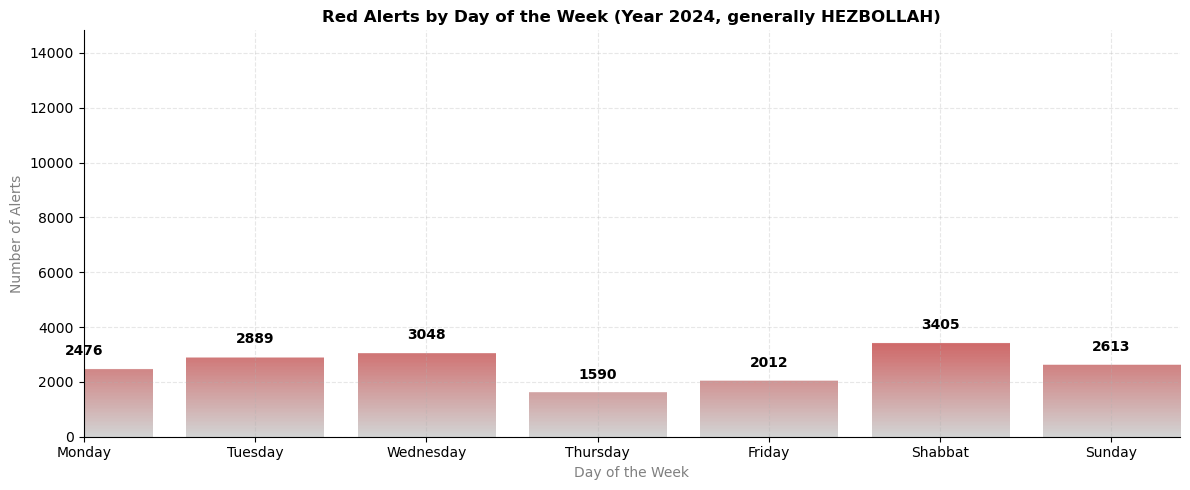

In [26]:
# Count alerts by weekday
alerts_by_weekday_hezbollah = hezbollah_attacks['weekday'].value_counts().sort_index()

# Convert numeric weekday to labels
alerts_by_weekday_hezbollah.index = weekday_labels

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))
bar_width = 0.8

# Iterate over each category (weekday) and its corresponding value (alerts)
for i, (day, value) in enumerate(zip(alerts_by_weekday_hezbollah.index, alerts_by_weekday_hezbollah.values)):
    left = i - bar_width / 2
    right = i + bar_width / 2

    # Create an alpha mask for the gradient:
    # alpha=1 from y=0 up to the bar's height
    # alpha=0 above the bar's height
    alpha_mask = np.ones((N, 1))
    for row in range(N):
        fraction = row / (N - 1)  # value in range [0..1]
        y_position = fraction * max_height
        if y_position > value:
            alpha_mask[row] = 0.0  # Make areas above the bar height transparent

    # Draw an "image" that covers [0..max_height] with the gradient
    ax.imshow(
        vertical,
        origin='lower',  # 0 at the bottom, 1 at the top
        cmap=cmap,       # use the gray->burgundy colormap
        extent=(left, right, 0, max_height),
        aspect='auto',
        alpha=alpha_mask  # apply transparency above the bar height
    )

    # Place a label on top of the bar
    ax.text(
        i, value + max_height * 0.03,  # Adjusted position for visibility
        str(int(value)),
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Configure the X-axis to place ticks at the center of each bar
ax.set_xticks(range(len(alerts_by_weekday_hezbollah)))
ax.set_xticklabels(alerts_by_weekday_hezbollah.index, rotation=0)

# Extend Y-axis slightly above the tallest bar
ax.set_ylim(0, max_height * 1.1)

# Draw a horizontal dashed grid with moderate opacity
ax.yaxis.grid(True, linestyle='--', alpha=0.3)

# Draw a vertical dashed grid for columns (lower opacity)
ax.set_axisbelow(True)
ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Label the axes and set a title
ax.set_xlabel("Day of the Week", color='gray')
ax.set_ylabel("Number of Alerts", color='gray')
ax.set_title("Red Alerts by Day of the Week (Year 2024, generally HEZBOLLAH)", 
             fontweight='bold')

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Auto-adjust layout to prevent label overlap
plt.tight_layout()
plt.show()


- **Highest attacks:** **Shabbat (Saturday)** (almost 13000 alarms) consistently shows the most alerts, indicating a strategic preference for attacks during the day of rest.
- **Tuesday is also high:** A significant number of attacks occur on **Tuesday**, marking another peak in alert activity. But this is because of the Iranian attack on October 1, 2024, when almost the entire territory of Israel came under fire.
- **Lowest activity:** **Thursday and Friday** register the fewest alerts, possibly reflecting operational pauses or strategic breaks before the weekend.
- **Fluctuations across the week:** The distribution of alerts varies notably by day, hinting at **strategic targeting** on specific days.

---

 **Attack Patterns Based on Time Periods**

- **Mainly by Hamas:**  
**Shabbat (Saturday)** had the highest number of alerts, exceeding 10,000. This suggests a deliberate strategy to target Israel’s day of rest, likely to maximize psychological impact and disrupt routines. **Tuesday** also saw a high volume of attacks, with alerts reaching around 7,000.
Sunday, Wednesday, and Thursday had moderate alert levels, ranging from 5,000 to 6,000.
Friday and Monday had the lowest number of alerts, both below 4,000, indicating that these days were less frequently targeted.


- **Mainly by Hezbollah:**  
  For Hezbollah, the difference is less significant - the largest number of alarms were also on **Shabbat** (more than 3,000). Then attacks appear more evenly distributed throughout the week, though still with a peak on Shabbat. The gradual decline towards the end of the week (Thursday and Friday) may indicate a shift in operational intensity or a response to strategic conditions.

---

🔍 **Key Insight:**  
The deliberate concentration of attacks on **Shabbat** underscores potential strategic motives aimed at disrupting routines and maximizing psychological impact. The **lower alert numbers on Thursday and Friday** suggest possible operational pauses or tactical considerations, while the shift from **Saturday to Tuesday** between the two groups (**Hamas** and **Hezbollah**) reveals evolving attack strategies over time.

---

### Conclusion

- **Hourly Trends:**
  
  - **Peak Hours:** Alerts surge at **19:00–20:00**.  
  - **Morning Rise:** Activity steadily increases from early morning, with a boost after **06:00**.  
  - **Night Decline:** Alerts drop after **20:00**, yet remain higher than the low between **05:00–06:00**.


- **Minute Distribution:**
  
  - A strong peak occurs in the **first 5 minutes** of each hour, with another rise around the **30th minute**.  
  - Approximately **23.62%** of alerts fall within ±5 minutes of the hour, and **18.70%** near the half-hour, suggesting intentional scheduling.


- **Attack Patterns:**
  
  - **Hamas:** 18.49% of alerts occur in the first 0–5 minutes, with a secondary peak at 30–35 minutes (11.71%).  
  - **Hezbollah:** Displays a more even spread, with 14.61% in the first 0–5 minutes and 10.76% in the 30–35 minute window.


- **Weekly Trends:**
  
  - **Shabbat (Saturday)** records the highest activity (~13,000 alerts), while **Thursday and Friday** see the fewest.  
  - **Tuesday** also shows a spike, partly due to major incidents.

---

🔍 **Key Insight:**  

The timing patterns reveal a strategic, non-random scheduling of attacks. Hamas tends to concentrate strikes at the top of the hour, while Hezbollah uses a more distributed approach. The high volume on Shabbat underscores a deliberate tactic to exploit periods of reduced vigilance.


## 🏙️ Cities and localities with the highest and lowest number of alerts

This section provides an in-depth analysis of the distribution of Red Alerts across different localities, focusing on the areas most and least affected by alerts. We examine trends both in the full dataset and specifically during the war period since October 7, 2023.

### Localities with the Highest Number of Alerts

We first identify the localities that experienced the highest number of alerts across two time periods:

- All-time alerts (2019–2024)
- Before October 7 2023
- Since October 7 2023

#### All-time (2019–2024)


To understand which areas are most affected, we will:
- **Identify localities with the most and least alerts**.
- Determine **which locations are persistently targeted**.

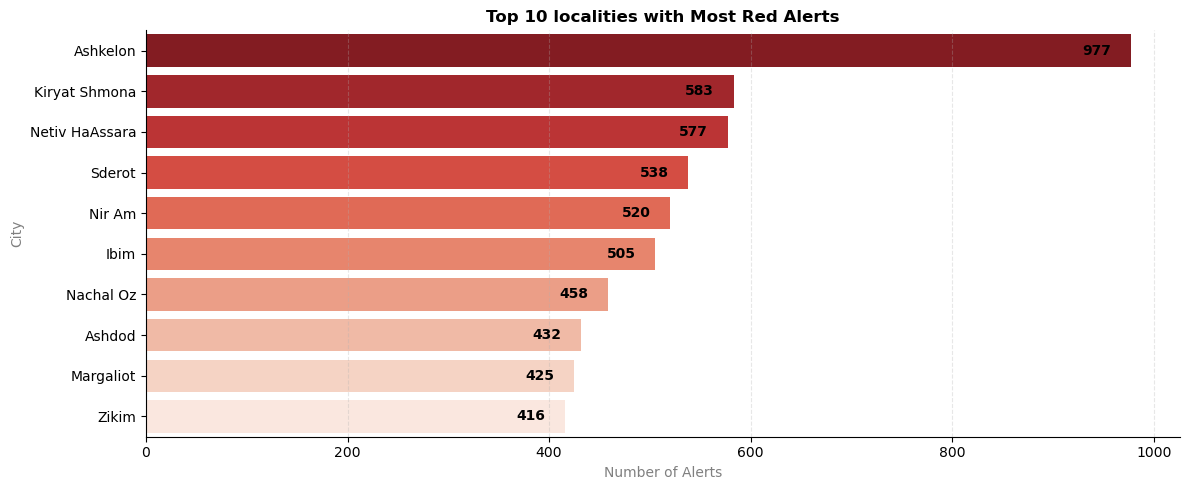

In [27]:
# Group data by city and count the number of alerts
top_localities = df['locality'].value_counts().nlargest(10)

plt.figure(figsize=(12, 5))
ax = sns.barplot(x=top_localities.values, y=top_localities.index, 
                 hue=top_localities.index, palette="Reds_r", legend=False)
plt.xlabel("Number of Alerts", color='gray')
plt.ylabel("City", color='gray')
plt.title("Top 10 localities with Most Red Alerts", fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.3)

offset = 0.02 * top_localities.values.max()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    y = p.get_y() + height / 2
    ax.text(width - offset, 
            y, 
            int(width), 
            ha='right', 
            va='center', 
            color='black', 
            fontsize=10, 
            fontweight='bold')  

sns.despine()
plt.tight_layout()
plt.show()


Most of these cities are located in **southern Israel**, near the **Gaza Strip**, including:  **Ashkelon** (977 alerts), **Netiv HaAsara** (577 alerts), **Sderot** (538 alerts), **Nir Am** (520), **Ibim** (505), **Nachal Oz** (458), **Zikim** (416).


However, two cities — **Kiryat Shmona** (583 alerts) and **Margaliot** (425 alerts) — are in the north, near the **Lebanese border**, indicating threats from different regions.

Let's see how the number of alarms in these localities has changed over the years.

#### Before October 2023

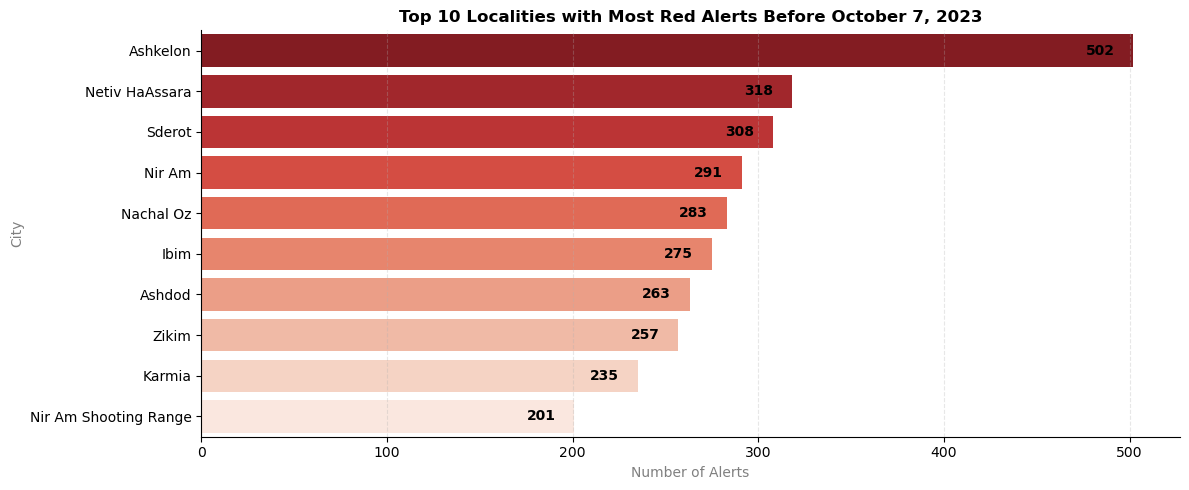

In [28]:
# Create a dataset with alerts before October 7, 2023
pre_war_df = df[df['datetime'] < war_start]
pre_war_df = pre_war_df.reset_index(drop=True)

# Group data by city and count the number of alerts before the war
pre_war_localities = pre_war_df['locality'].value_counts().nlargest(10)

# Create the figure and bar plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=pre_war_localities.values, y=pre_war_localities.index, 
                 hue=pre_war_localities.index, palette="Reds_r", legend=False)
plt.xlabel("Number of Alerts", color='gray')  # Label for the x-axis
plt.ylabel("City", color='gray')  # Label for the y-axis
plt.title("Top 10 Localities with Most Red Alerts Before October 7, 2023", 
          fontweight='bold')  # Chart title
plt.grid(axis="x", linestyle="--", alpha=0.3)
sns.despine()  # Remove top and right spines for a cleaner look
plt.tight_layout()

# Add annotations to display the exact number of alerts
offset = 0.02 * pre_war_localities.values.max()  # Offset to position text labels
for p in ax.patches:
    width = p.get_width()  # Get bar width (alert count)
    height = p.get_height()  # Get bar height
    y = p.get_y() + height / 2  # Calculate y-position for text label
    ax.text(width - offset,  # Position text slightly inside the bar
            y, 
            int(width),  # Display alert count as integer
            ha='right',  # Align text to the right
            va='center',  # Vertically center text
            color='black', 
            fontsize=10, 
            fontweight='bold')

plt.show()  # Display the plot


**Ashkelon** recorded the highest number of alerts (502), making it the most affected locality. **Netiv HaAssara** had (318 alerts), **Sderot** had 308 alerts.
 
All settlements are located in **southern Israel**, near the **Gaza Strip**.


#### Since October 2023

In [29]:
# Creating a dataset starting from the date of October 7, 2023
last_war_df = df[df['datetime'] >= war_start]
last_war_df = last_war_df.reset_index(drop=True)
last_war_df

,datetime,locality,zones,region,threat_type
0,2023-10-07 06:29:02,Bat Yam,All,Dan,Red Alert
1,2023-10-07 06:29:02,Palmachim,All,Lachish,Red Alert
2,2023-10-07 06:29:02,Rishon LeZion,West,HaShfela,Red Alert
3,2023-10-07 06:29:03,Netiv HaAssara,All,Gaza Envelope,Red Alert
4,2023-10-07 06:29:04,Yad Mordechai,All,Gaza Envelope,Red Alert
...,...,...,...,...,...
43468,2025-01-18 15:39:27,Eilot,All,Eilat,Red Alert
43469,2025-01-18 15:39:28,Shchoret Industrial Zone,All,Eilat,Red Alert
43470,2025-01-19 09:00:14,Ibim,All,Gaza Envelope,Red Alert
43471,2025-01-19 09:00:14,Sderot,All,Gaza Envelope,Red Alert


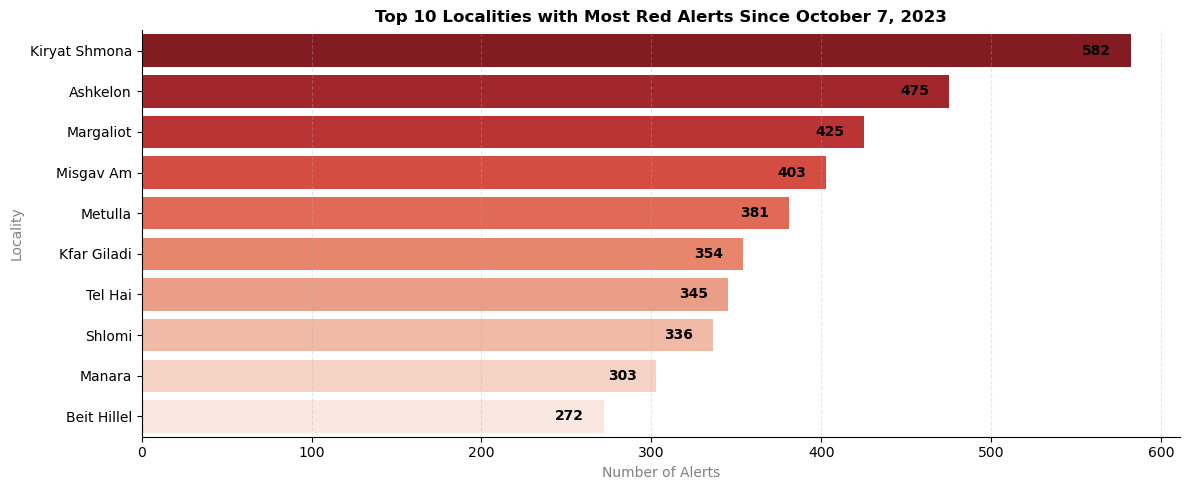

In [30]:
# Group data by city and count the number of alerts
war_localities = last_war_df['locality'].value_counts().nlargest(10)

# Create the figure and bar plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=war_localities.values, y=war_localities.index, 
                 hue=war_localities.index, palette="Reds_r", legend=False)
plt.xlabel("Number of Alerts", color='gray')  # Label for the x-axis
plt.ylabel("Locality", color='gray')  # Label for the y-axis
plt.title("Top 10 Localities with Most Red Alerts Since October 7, 2023", 
          fontweight='bold')  # Chart title
plt.grid(axis="x", linestyle="--", alpha=0.3)

sns.despine()  # Remove top and right spines for a cleaner look
plt.tight_layout()

# Add annotations to display the exact number of alerts
offset = 0.02 * war_localities.values.max()  # Offset to position text labels
for p in ax.patches:
    width = p.get_width()  # Get bar width (alert count)
    height = p.get_height()  # Get bar height
    y = p.get_y() + height / 2  # Calculate y-position for text label
    ax.text(width - offset,  # Position text slightly inside the bar
            y, 
            int(width),  # Display alert count as integer
            ha='right',  # Align text to the right
            va='center',  # Vertically center text
            color='black', 
            fontsize=10, 
            fontweight='bold')

plt.show()  # Display the plot


The **new most affected localities** were **Kiryat Shmona (582), Margaliot (425), and Misgav Am (403)**, all situated near the **Lebanese border**. The only southern locality on the list was **Ashkelon** with **475 alerts**.


---

**Conclusion:**

Generally, **Ashkelon** (977 alerts), **Kiryat Shmona** (583 alerts), **Netiv HaAsara** (577 alerts) experienced the highest number of alerts. While many of these locations are in **southern Israel, near the Gaza Strip**, the presence of **Kiryat Shmona and Margaliot** suggests significant threats from **northern Israel, near the Lebanese border**. 


1. **Before the war (pre-October 7, 2023):**  
   - The **most targeted cities** were concentrated in **southern Israel**, particularly near the **Gaza Strip**.  
   - The **top three localities** with the highest number of alerts were **Ashkelon (502), Netiv HaAsara (318), and Sderot (308)**.  
   - All **top 10 cities** were located in **southern Israel**, showing a **consistent threat from Gaza**.


2. **After the war started (post-October 7, 2023):**  
   - A **dramatic shift** occurred, with **northern Israel** becoming the **primary target**.
   - The **new top localities** were **Kiryat Shmona (582), Margaliot (425), and Misgav Am (403)**, all located near the **Lebanese border**. The only settlement in the south was **Ashkelon** (475).


---

🔍 **Key Insight:**  
- **The war significantly altered the security landscape**, shifting **the most affected localities from the south to the north**.
- The **Gaza Strip** remained a **major source of attacks**, but **northern cities became key targets after October 7**, indicating **an escalation in hostilities from Lebanon**.


### Important localities with the highest and lowest number of alerts

We identified the maximum and minimum number of alerts across all localities. Next, we focused on the same metrics (max and min) specifically for the most populous or strategically significant localities, defined in the `important_cities` list.

#### All-time (2019–2024)

In [31]:
# List of important cities
important_cities = [
    "Eilat", "Modi'in", "Hadera", "Caesarea", "Ramat Gan", "Haifa", "Beer Sheva", "Netanya",
    "Rishon LeZion", "Tel Aviv", "Ashdod", "Herzeliya", "Jerusalem", "Beit Shemesh",
    "Ashkelon", "Rehovot", "Lod", "Ramla", "Holon", "Bat Yam", "Kfar Saba",
    "Petah Tikva", "Tiberias", "Nahariya", "Safed", "Kiryat Shmona", "Acre",
    "Ma'ale Adumim", "Ariel", "Nazareth", "Atlit", "Sderot", "Ofakim", 
    "Dimona", "Yavne", "Kiryat Gat", "Kiryat Malakhi", "Migdal HaEmek", "Or Akiva",
    "Be'er Ya'akov", "Givatayim", "Yokneam", "Tirat Carmel", "Karmiel", "Arad",
    "Ma'alot-Tarshiha", "Kiryat Ata", "Kiryat Bialik", "Kiryat Yam", "Kiryat Motzkin",
    "Nesher", "Afula"
]


# Filter the DataFrame to include only the important cities
filtered_df = df[df['locality'].isin(important_cities)]

# Count alerts by city
alerts_by_city = filtered_df['locality'].value_counts().reset_index()
alerts_by_city.columns = ['locality', 'Number of Alerts']

# Get top 10 cities with the highest number of alerts
top_cities = alerts_by_city.head(10)

# Get bottom 10 cities with the lowest number of alerts
bottom_cities = alerts_by_city.tail(10)

# Display results
print("Top 10 Cities with the Most Alerts:")
top_cities

Top 10 Cities with the Most Alerts:


,locality,Number of Alerts
0,Ashkelon,977
1,Kiryat Shmona,583
2,Sderot,538
3,Ashdod,432
4,Nahariya,251
5,Acre,251
6,Beer Sheva,232
7,Rishon LeZion,214
8,Safed,210
9,Tel Aviv,179


In [32]:
print("\nBottom 10 Cities with the Least Alerts:")
bottom_cities


Bottom 10 Cities with the Least Alerts:


,locality,Number of Alerts
35,Tiberias,22
36,Netanya,21
37,Dimona,20
38,Caesarea,20
39,Migdal HaEmek,20
40,Atlit,18
41,Nazareth,18
42,Afula,13
43,Or Akiva,12
44,Ariel,9


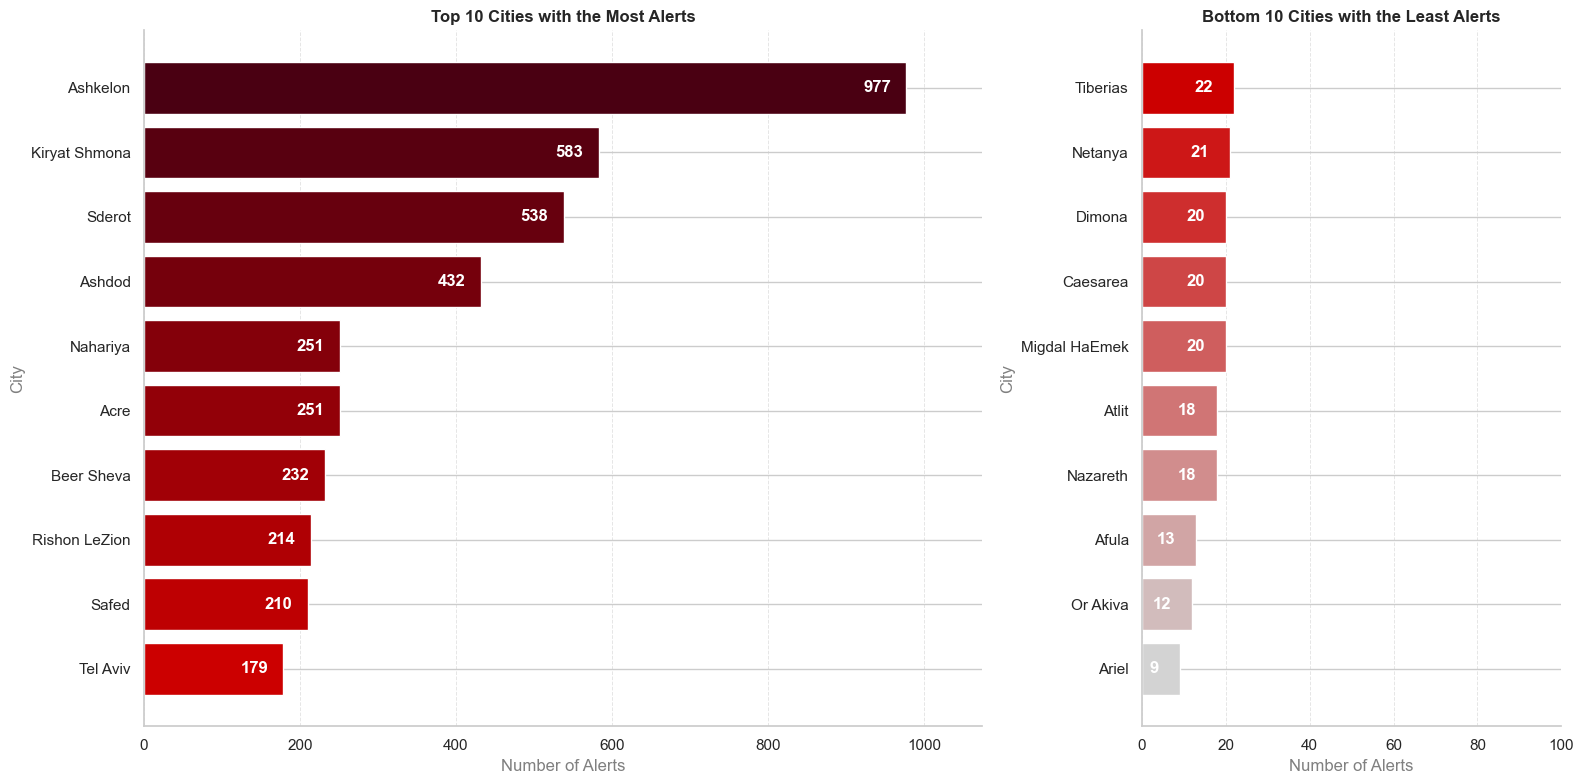

In [33]:
# Set a clean whitegrid style
sns.set_theme(style="whitegrid")

# Sort the data so that the largest "Number of Alerts" is first
top_cities_sorted = top_cities.sort_values("Number of Alerts", ascending=False).reset_index(drop=True)
bottom_cities_sorted = bottom_cities.sort_values("Number of Alerts", ascending=False).reset_index(drop=True)

# Create gradient palettes
# Top 10: from dark burgundy (#4A0012) to red (#CC0000)
top_colors = sns.blend_palette(["#4A0012", "#CC0000"], n_colors=len(top_cities_sorted))

# Bottom 10: from red (#CC0000) to gray (#999999)
bottom_colors = sns.blend_palette(["#CC0000", "#D3D3D3"], n_colors=len(bottom_cities_sorted))

# Determine a maximum for the top 10 x-axis
max_alerts = top_cities_sorted["Number of Alerts"].max()
x_limit_top = max_alerts * 1.1  # Add some space on the right

# Manually set the bottom 10 x-axis to 100
x_limit_bottom = 100

# Create subplots with a 2:1 width ratio
fig, (ax_top, ax_bottom) = plt.subplots(
    1, 2, figsize=(16, 8),
    gridspec_kw={'width_ratios': [2, 1]}
)

# ------------------------------------------------------------------------------
# Plot for Top 10 Cities
# ------------------------------------------------------------------------------
bars_top = ax_top.barh(
    y=top_cities_sorted["locality"], 
    width=top_cities_sorted["Number of Alerts"], 
    color=top_colors
)

# Invert y-axis so that the city with the largest alerts is on top
ax_top.invert_yaxis()

# Add numerical labels on each bar for Top 10
offset_top = max_alerts * 0.02
for bar, alerts in zip(bars_top, top_cities_sorted["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # Place label inside the bar
    ax_top.text(
        x_pos - offset_top, y_pos, 
        str(alerts),
        color='white', ha='right', va='center',
        fontweight='bold', fontsize=12
    )

# Customizing grid lines: thin, dashed, and semi-transparent
ax_top.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Axis labels and title for top 10
ax_top.set_xlim(0, x_limit_top)
ax_top.set_title("Top 10 Cities with the Most Alerts", fontweight='bold')
ax_top.set_xlabel("Number of Alerts", color='gray')
ax_top.set_ylabel("City", color='gray')

# ------------------------------------------------------------------------------
# Plot for Bottom 10 Cities
# ------------------------------------------------------------------------------
bars_bottom = ax_bottom.barh(
    y=bottom_cities_sorted["locality"], 
    width=bottom_cities_sorted["Number of Alerts"], 
    color=bottom_colors
)

# Invert y-axis so that the city with the largest alerts in the bottom group is on top
ax_bottom.invert_yaxis()

# We will use a small offset and dynamically decide where to place the text
offset_bottom = x_limit_bottom * 0.05  # 5% of the chosen x-limit

# Add numerical labels on each bar for Bottom 10
for bar, alerts in zip(bars_bottom, bottom_cities_sorted["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    
    # If the bar is wide enough to hold the text internally, place it inside
    if x_pos > offset_bottom:
        ax_bottom.text(
            x_pos - offset_bottom, y_pos, 
            str(alerts),
            color='white', ha='right', va='center',
            fontweight='bold', fontsize=12
        )
    else:
        # Otherwise, place the text just outside the bar, to the right
        ax_bottom.text(
            x_pos + (offset_bottom / 2), y_pos, 
            str(alerts),
            color='black', ha='left', va='center',
            fontweight='bold', fontsize=12
        )

# Customizing grid lines: thin, dashed, and semi-transparent
ax_bottom.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Axis labels and title for bottom 10
ax_bottom.set_xlim(0, x_limit_bottom)
ax_bottom.set_title("Bottom 10 Cities with the Least Alerts", fontweight='bold')
ax_bottom.set_xlabel("Number of Alerts", color='gray')
ax_bottom.set_ylabel("City", color='gray')

# Remove spines for a cleaner look
sns.despine()

# Adjust spacing so titles and labels look good
plt.tight_layout()
plt.show()


In [34]:
# Display the full list of important cities with alert counts
alerts_by_city

,locality,Number of Alerts
0,Ashkelon,977
1,Kiryat Shmona,583
2,Sderot,538
3,Ashdod,432
4,Nahariya,251
5,Acre,251
6,Beer Sheva,232
7,Rishon LeZion,214
8,Safed,210
9,Tel Aviv,179


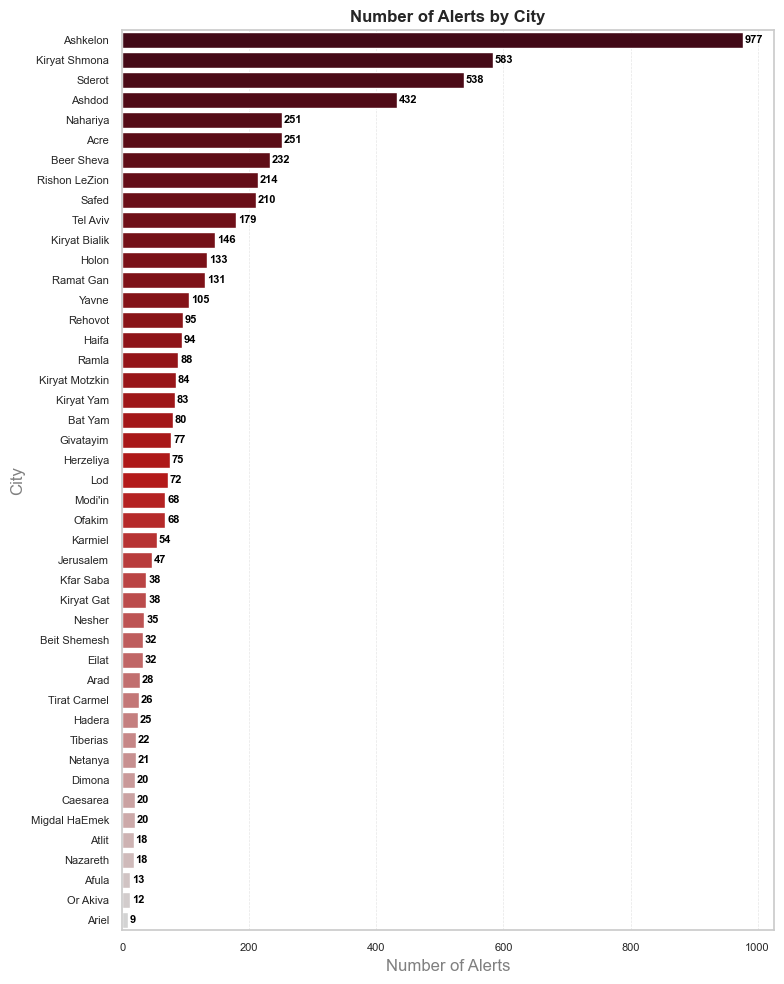

In [35]:
# Define a list of base colors for the gradient
base_colors = ["#4A0012", "#CC0000", "#D3D3D3"]

# Generate a custom gradient palette
colors = sns.blend_palette(base_colors, n_colors=len(alerts_by_city), as_cmap=False)

# Create figure
plt.figure(figsize=(8, 10))

# Create a horizontal bar plot with a gradient color palette
ax = sns.barplot(
    data=alerts_by_city,
    x="Number of Alerts",
    y="locality",
    hue="locality",
    dodge=False,
    palette=colors,
    legend=False
)

# Add labels **outside** each bar in black color
for container in ax.containers:
    for bar in container:
        x_pos = bar.get_width()  # Bar length
        y_pos = bar.get_y() + bar.get_height() / 2  # Center the label
        ax.text(
            x_pos + 3, y_pos,  # Always place text outside the bar
            int(x_pos),
            ha='left', va='center',
            fontsize=8, color='black', fontweight='bold'
        )

# Customize plot appearance
ax.set_title("Number of Alerts by City", fontweight='bold')
ax.set_xlabel("Number of Alerts", color='gray')
ax.set_ylabel("City", color='gray')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick label size

# Customize grid lines: thin, dashed, and semi-transparent
ax.grid(axis='x', linestyle='dashed', linewidth=0.5, alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


**Ashkelon (977 alerts)**, **Kiryat Shmona (583 alerts), Sderot (538), and Ashdod (432)** experienced the highest number of alerts, indicating heavy exposure to attacks. In contrast, cities such as **Tiberias (22 alerts), Netanya (21), and Ariel (9)** had the fewest alerts, showing a much lower level of threat. This contrast highlights regional differences in security risks, with some areas experiencing **over 60 times more alerts** than others.ties.

#### Before October 2023

In [36]:
# Filter the DataFrame to include only the important cities (pre-war data)
filtered_df_pre_war = pre_war_df[pre_war_df['locality'].isin(important_cities)]

# Count alerts by city (pre-war data)
alerts_by_city_pre_war = filtered_df_pre_war['locality'].value_counts().reset_index()
alerts_by_city_pre_war.columns = ['City', 'Number of Alerts']

# Get top 10 cities with the highest number of alerts (pre-war data)
top_cities_pre_war = alerts_by_city_pre_war.head(10)

# Get bottom 10 cities with the lowest number of alerts (pre-war data)
bottom_cities_pre_war = alerts_by_city_pre_war.tail(10)

# Display results (pre-war data)
print("Top 10 Cities (Pre-War) with the Most Alerts:")
top_cities_pre_war


Top 10 Cities (Pre-War) with the Most Alerts:


,City,Number of Alerts
0,Ashkelon,502
1,Sderot,308
2,Ashdod,263
3,Beer Sheva,117
4,Rishon LeZion,62
5,Tel Aviv,48
6,Yavne,41
7,Holon,39
8,Ofakim,38
9,Ramat Gan,36


In [37]:
print("\nBottom 10 Cities (Pre-War) with the Least Alerts:")
bottom_cities_pre_war


Bottom 10 Cities (Pre-War) with the Least Alerts:


,City,Number of Alerts
25,Kiryat Bialik,2
26,Or Akiva,2
27,Caesarea,2
28,Arad,2
29,Kiryat Yam,2
30,Kiryat Shmona,1
31,Atlit,1
32,Kiryat Motzkin,1
33,Eilat,1
34,Karmiel,1


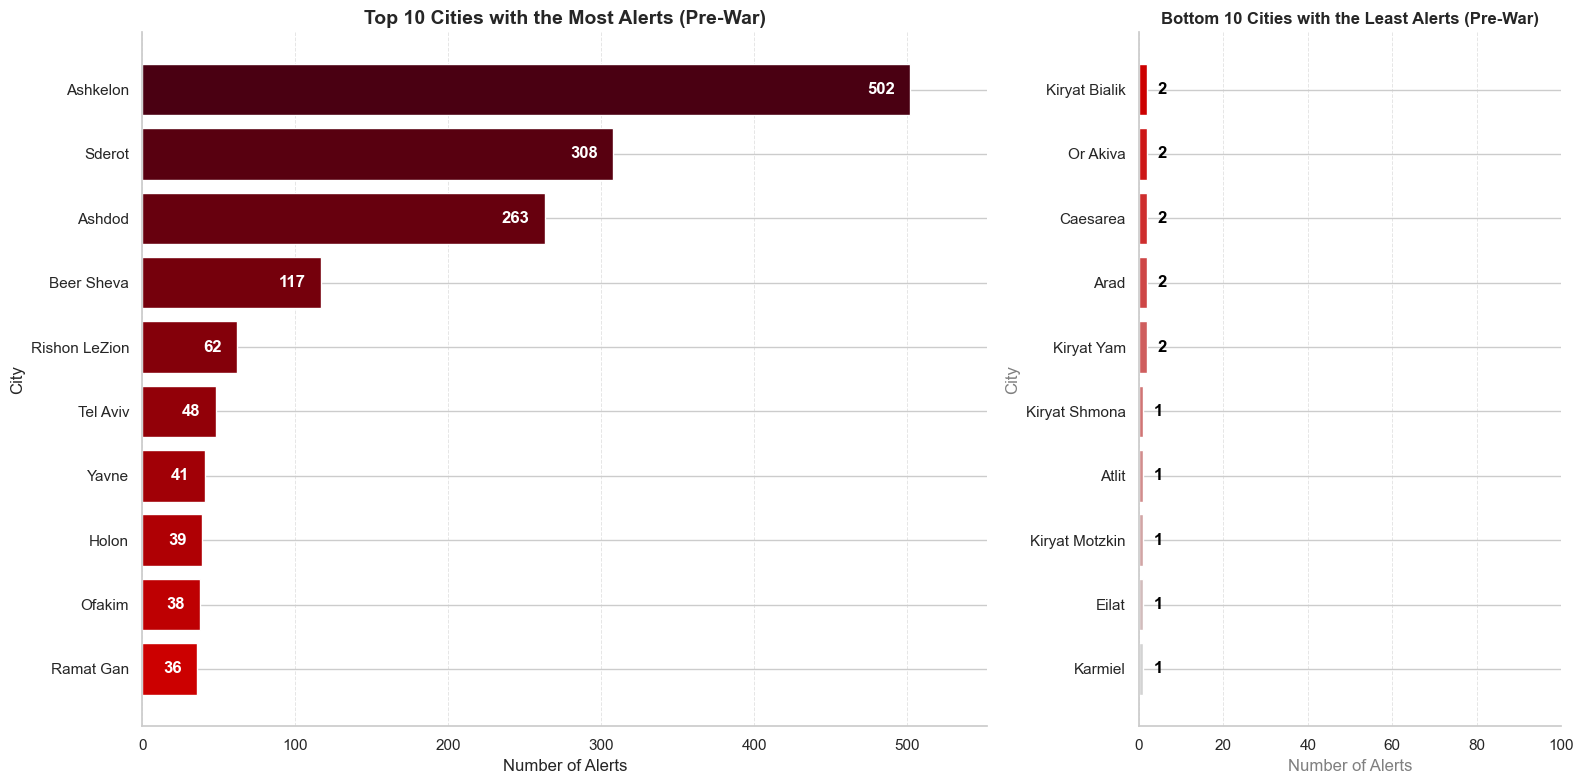

In [38]:
# Sort the pre-war data so that the largest "Number of Alerts" is first
top_cities_sorted = top_cities_pre_war.sort_values("Number of Alerts", ascending=False).reset_index(drop=True)
bottom_cities_sorted = bottom_cities_pre_war.sort_values("Number of Alerts", ascending=False).reset_index(drop=True)

# Create gradient palettes for pre-war data
# Top 10: from dark burgundy (#4A0012) to red (#CC0000)
top_colors = sns.blend_palette(["#4A0012", "#CC0000"], n_colors=len(top_cities_sorted))

# Bottom 10: from red (#CC0000) to gray (#999999)
bottom_colors = sns.blend_palette(["#CC0000", "#D3D3D3"], n_colors=len(bottom_cities_sorted))

# Determine the maximum value for the top 10 x-axis
max_alerts = top_cities_sorted["Number of Alerts"].max()
x_limit_top = max_alerts * 1.1  # add 10% extra space on the right

# Manually set the bottom 10 x-axis to 100
x_limit_bottom = 100

# Create subplots with a 2:1 width ratio
fig, (ax_top, ax_bottom) = plt.subplots(
    1, 2, figsize=(16, 8),
    gridspec_kw={'width_ratios': [2, 1]}
)

# ------------------------------------------------------------------------------
# Plot for Top 10 Cities (Pre-War)
# ------------------------------------------------------------------------------
bars_top = ax_top.barh(
    y=top_cities_sorted["City"],
    width=top_cities_sorted["Number of Alerts"],
    color=top_colors
)

# Invert y-axis so that the city with the largest alerts is on top
ax_top.invert_yaxis()

# Add numerical labels on each bar for Top 10
offset_top = max_alerts * 0.02
for bar, alerts in zip(bars_top, top_cities_sorted["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax_top.text(
        x_pos - offset_top, y_pos,
        str(alerts),
        color='white', ha='right', va='center',
        fontweight='bold', fontsize=12
    )

# Customize grid lines: thin, dashed, and semi-transparent
ax_top.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Set axis labels and title for Top 10
ax_top.set_xlim(0, x_limit_top)
ax_top.set_title("Top 10 Cities with the Most Alerts (Pre-War)", fontsize=14, fontweight='bold')
ax_top.set_xlabel("Number of Alerts", fontsize=12)
ax_top.set_ylabel("City", fontsize=12)

# ------------------------------------------------------------------------------
# Plot for Bottom 10 Cities (Pre-War)
# ------------------------------------------------------------------------------
bars_bottom = ax_bottom.barh(
    y=bottom_cities_sorted["City"],
    width=bottom_cities_sorted["Number of Alerts"],
    color=bottom_colors
)

# Invert y-axis so that the city with the largest alerts is on top
ax_bottom.invert_yaxis()

# Use a small offset for label placement on Bottom 10
offset_bottom = x_limit_bottom * 0.05  # 5% of the chosen x-limit

# Add numerical labels on each bar for Bottom 10
for bar, alerts in zip(bars_bottom, bottom_cities_sorted["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    # If the bar is wide enough, place the label inside the bar
    if x_pos > offset_bottom:
        ax_bottom.text(
            x_pos - offset_bottom, y_pos,
            str(alerts),
            color='white', ha='right', va='center',
            fontweight='bold', fontsize=12
        )
    else:
        # Otherwise, place the label just outside the bar
        ax_bottom.text(
            x_pos + (offset_bottom / 2), y_pos,
            str(alerts),
            color='black', ha='left', va='center',
            fontweight='bold', fontsize=12
        )

# Customize grid lines: thin, dashed, and semi-transparent
ax_bottom.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Set axis labels and title for Bottom 10
ax_bottom.set_xlim(0, x_limit_bottom)
ax_bottom.set_title("Bottom 10 Cities with the Least Alerts (Pre-War)", 
                    fontweight='bold')
ax_bottom.set_xlabel("Number of Alerts", color='gray')
ax_bottom.set_ylabel("City", color='gray')

# Remove top and right spines for a cleaner look
sns.despine()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


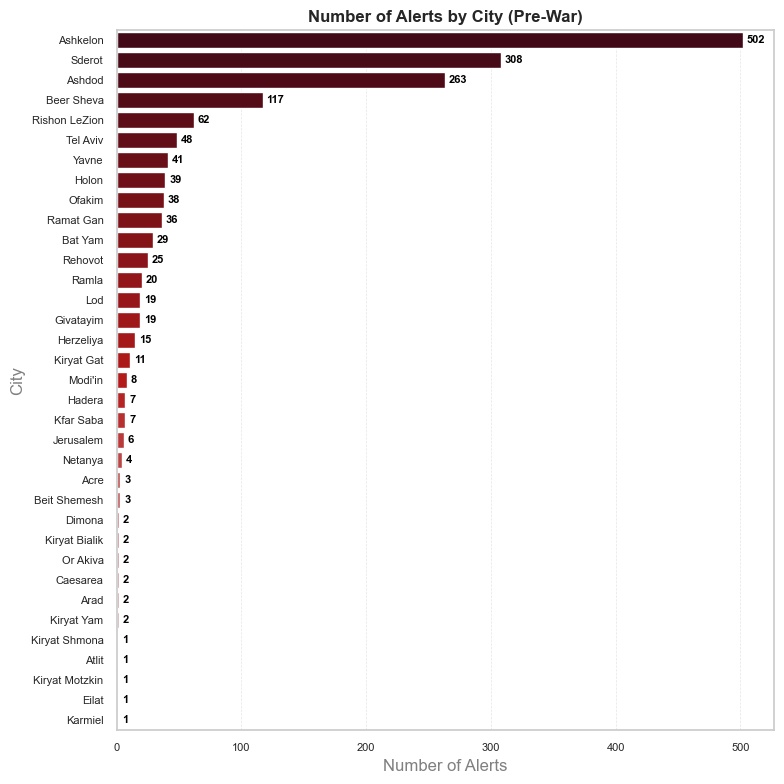

In [39]:
# Create a continuous colormap
colormap = sns.blend_palette(base_colors, as_cmap=True)

# Get unique cities and determine the number of discrete colors needed
unique_cities = alerts_by_city_pre_war['City'].unique()
num_unique_cities = len(unique_cities)

# Generate an array of evenly spaced values from 0 to 1;
# each value corresponds to a point in the colormap.
color_positions = np.linspace(0, 1, num_unique_cities)

# Build a discrete palette by sampling from the colormap
palette_for_plot = [colormap(pos) for pos in color_positions]

# Create figure
plt.figure(figsize=(8, 8))

# Create a horizontal bar plot with a sampled gradient color palette
ax = sns.barplot(
    data=alerts_by_city_pre_war,
    x="Number of Alerts",
    y="City",
    hue="City",
    dodge=False,
    palette=palette_for_plot,  # Exact number of needed colors
    legend=False
)

# Add labels **outside** each bar in black color
for container in ax.containers:
    for bar in container:
        x_pos = bar.get_width()  # Bar length
        y_pos = bar.get_y() + bar.get_height() / 2  # Center the label
        ax.text(
            x_pos + 3, y_pos,  # Always place text outside the bar
            int(x_pos),
            ha='left', va='center',
            fontsize=8, color='black', fontweight='bold'
        )

# Customize plot appearance
ax.set_title("Number of Alerts by City (Pre-War)", fontweight='bold')
ax.set_xlabel("Number of Alerts", color='gray')
ax.set_ylabel("City", color='gray')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick label size

# Customize grid lines: thin, dashed, and semi-transparent
ax.grid(axis='x', linestyle='dashed', linewidth=0.5, alpha=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()



**Ashkelon (502 alerts), Sderot (308 alerts), Ashdod (263), and Beer Sheva (117)** experienced the highest number of alerts before the war, indicating these cities were already facing significant security threats. In contrast, cities such as **Caesarea (2 alerts), Arad (2), and Kiryat Shmona (1)** had the fewest alerts, showing a much lower level of threats.

#### Since October 2023
Now let's count the alarms for the last war only, starting from October 7, 2023

In [40]:
# Filter the last war DataFrame to include only the important cities
filtered_df_war = last_war_df[last_war_df['locality'].isin(important_cities)]

# Count alerts by city for the last war period
alerts_by_city_war = filtered_df_war['locality'].value_counts().reset_index()
alerts_by_city_war.columns = ['City', 'Number of Alerts']

# Get top 10 cities with the highest number of alerts during the last war
top_cities_war = alerts_by_city_war.head(10)

# Get bottom 10 cities with the lowest number of alerts during the last war
bottom_cities_war = alerts_by_city_war.tail(10)

# Display results
print("Top 10 Cities with the Most Alerts Since October 2023:")
print(top_cities_war)

print("\nBottom 10 Cities with the Least Alerts Since October 2023:")
print(bottom_cities_war)


Top 10 Cities with the Most Alerts Since October 2023:
            City  Number of Alerts
0  Kiryat Shmona               582
1       Ashkelon               475
2       Nahariya               251
3           Acre               248
4         Sderot               230
5          Safed               210
6         Ashdod               169
7  Rishon LeZion               152
8  Kiryat Bialik               144
9       Tel Aviv               131

Bottom 10 Cities with the Least Alerts Since October 2023:
             City  Number of Alerts
35  Migdal HaEmek                20
36       Nazareth                18
37         Dimona                18
38       Caesarea                18
39         Hadera                18
40          Atlit                17
41        Netanya                17
42          Afula                13
43       Or Akiva                10
44          Ariel                 9


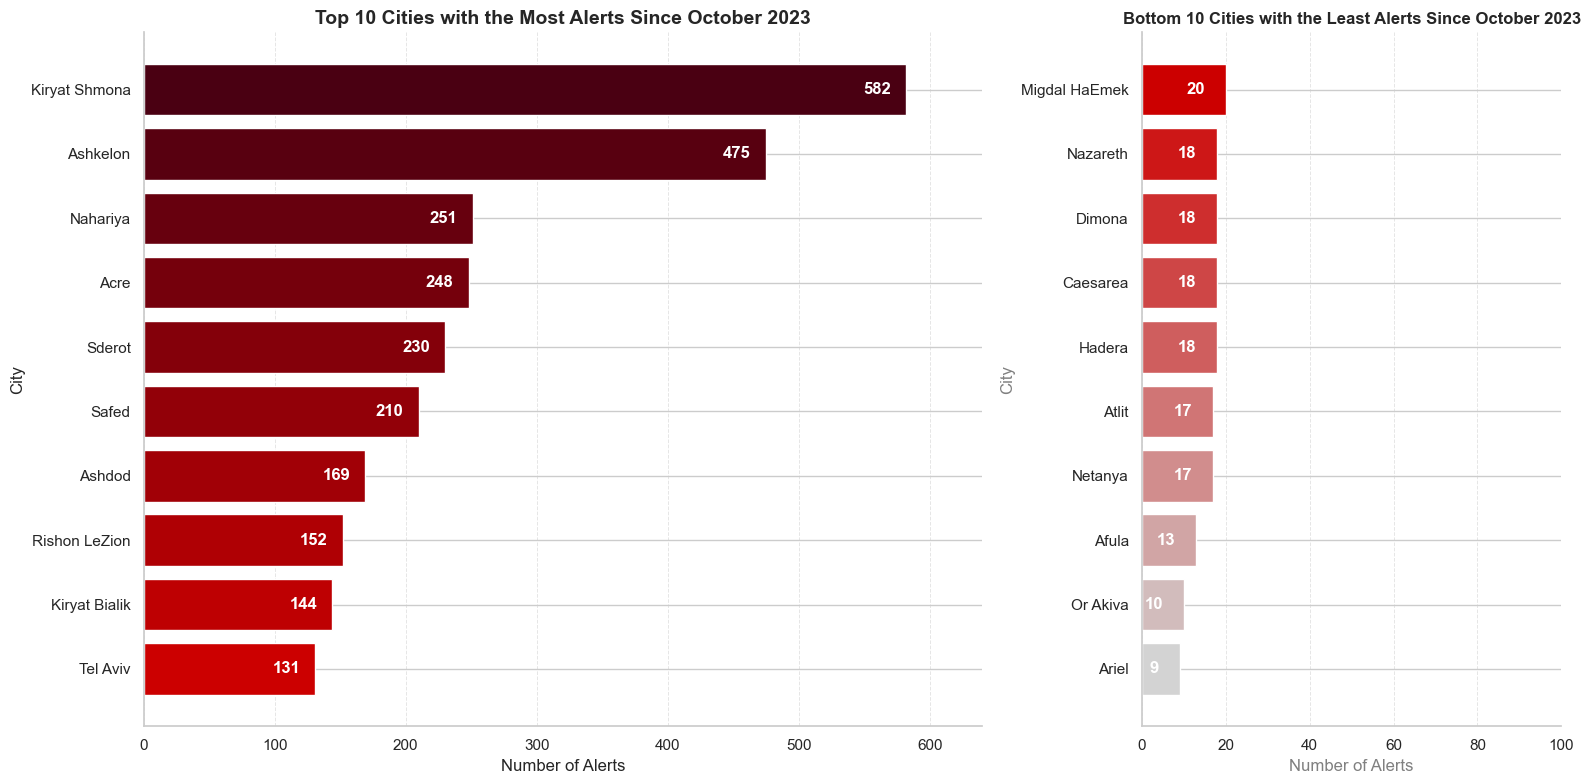

In [41]:
# Filter the last war DataFrame to include only the important cities
filtered_df_war = last_war_df[last_war_df['locality'].isin(important_cities)]

# Count alerts by city for the last war period
alerts_by_city_war = filtered_df_war['locality'].value_counts().reset_index()
alerts_by_city_war.columns = ['City', 'Number of Alerts']

# Get top 10 cities with the highest number of alerts during the last war
top_cities_war = alerts_by_city_war.head(10)

# Get bottom 10 cities with the lowest number of alerts during the last war
bottom_cities_war = alerts_by_city_war.tail(10)

# Set a clean whitegrid style
sns.set_theme(style="whitegrid")

# Create gradient palettes for the war data
# Top 10: from dark burgundy (#4A0012) to red (#CC0000)
top_colors = sns.blend_palette(["#4A0012", "#CC0000"], n_colors=len(top_cities_war))

# Bottom 10: from red (#CC0000) to gray (#999999)
bottom_colors = sns.blend_palette(["#CC0000", "#D3D3D3"], n_colors=len(bottom_cities_war))

# Determine maximum alerts for top cities and set x-axis limits
max_alerts_war = top_cities_war["Number of Alerts"].max()
x_limit_top = max_alerts_war * 1.1  # 10% extra space for top plot
x_limit_bottom = 100               # Manually set for bottom plot

# Create subplots with a 2:1 width ratio
fig, (ax_top, ax_bottom) = plt.subplots(
    1, 2, figsize=(16, 8),
    gridspec_kw={'width_ratios': [2, 1]}
)

# ------------------------------------------------------------------------------
# Plot for Top 10 Cities (Last War)
# ------------------------------------------------------------------------------
bars_top = ax_top.barh(
    y=top_cities_war['City'],
    width=top_cities_war['Number of Alerts'],
    color=top_colors
)
# Invert y-axis so that the city with the highest alerts appears at the top
ax_top.invert_yaxis()

# Add numerical labels on each bar for Top 10 using an offset (2% of max)
offset_top_war = max_alerts_war * 0.02
for bar, alerts in zip(bars_top, top_cities_war["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax_top.text(
        x_pos - offset_top_war, y_pos,
        str(alerts),
        color='white', ha='right', va='center',
        fontweight='bold', fontsize=12
    )

# Customize grid lines: thin, dashed, and 50% transparent
ax_top.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Set axis labels and title for Top 10
ax_top.set_xlim(0, x_limit_top)
ax_top.set_title("Top 10 Cities with the Most Alerts Since October 2023", 
                 fontsize=14, fontweight='bold')
ax_top.set_xlabel("Number of Alerts", fontsize=12)
ax_top.set_ylabel("City", fontsize=12)

# ------------------------------------------------------------------------------
# Plot for Bottom 10 Cities (Last War)
# ------------------------------------------------------------------------------
bars_bottom = ax_bottom.barh(
    y=bottom_cities_war['City'],
    width=bottom_cities_war['Number of Alerts'],
    color=bottom_colors
)
# Invert y-axis so that the city with the highest alerts in the bottom group is on top
ax_bottom.invert_yaxis()

# Use a small offset for label placement (5% of the x-axis limit for bottom)
offset_bottom_war = x_limit_bottom * 0.05

# Add numerical labels on each bar for Bottom 10
for bar, alerts in zip(bars_bottom, bottom_cities_war["Number of Alerts"]):
    x_pos = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    # If the bar is wide enough, place the label inside the bar
    if x_pos > offset_bottom_war:
        ax_bottom.text(
            x_pos - offset_bottom_war, y_pos,
            str(alerts),
            color='white', ha='right', va='center',
            fontweight='bold', fontsize=12
        )
    else:
        # Otherwise, place the label just outside the bar
        ax_bottom.text(
            x_pos + (offset_bottom_war / 2), y_pos,
            str(alerts),
            color='black', ha='left', va='center',
            fontweight='bold', fontsize=12
        )

# Customize grid lines for bottom plot: thin, dashed, and 50% transparent
ax_bottom.grid(axis='x', linestyle='dashed', linewidth=0.7, alpha=0.5)

# Set axis labels and title for Bottom 10
ax_bottom.set_xlim(0, x_limit_bottom)
ax_bottom.set_title("Bottom 10 Cities with the Least Alerts Since October 2023", 
                    fontweight='bold')
ax_bottom.set_xlabel("Number of Alerts", color='gray')
ax_bottom.set_ylabel("City", color='gray')

# Remove top and right spines for a cleaner look
sns.despine()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


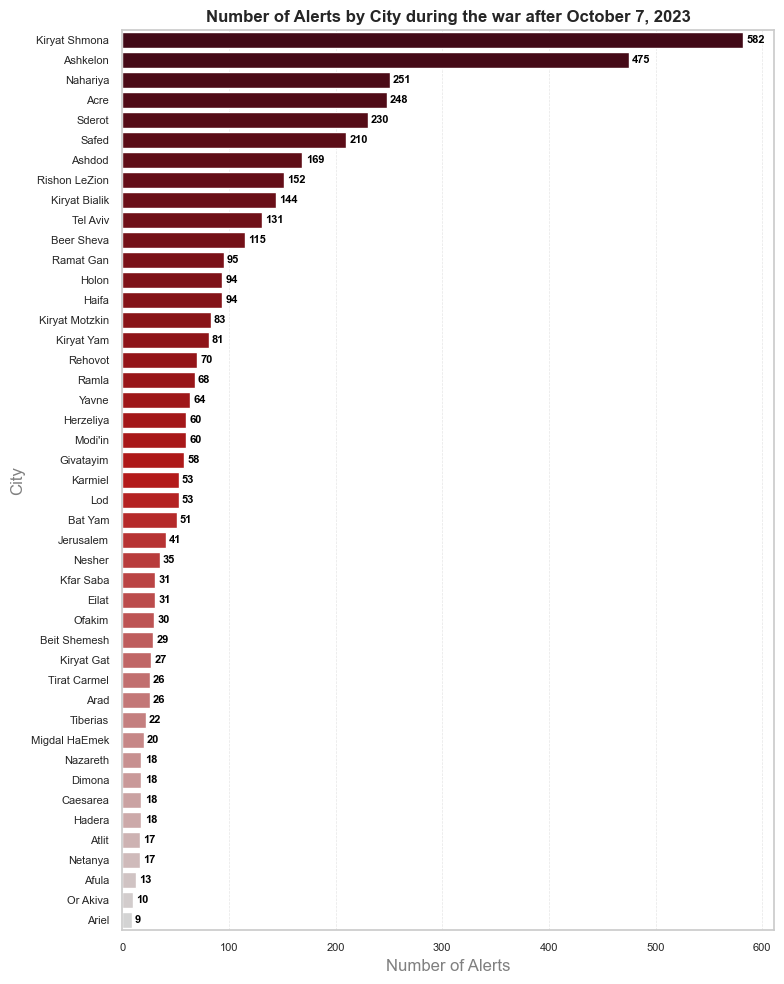

In [42]:
# Identify all unique cities in the dataset
unique_cities = alerts_by_city_war['City'].unique()
num_unique_cities = len(unique_cities)

# Generate evenly spaced points from 0 to 1 to sample the colormap
color_positions = np.linspace(0, 1, num_unique_cities)

# Create a discrete list of colors from the continuous gradient
palette_for_plot = [colormap(pos) for pos in color_positions]

# Create figure
plt.figure(figsize=(8, 10))

# Create a horizontal bar plot with a sampled gradient color palette
ax = sns.barplot(
    data=alerts_by_city_war,
    x="Number of Alerts",
    y="City",
    hue="City",
    dodge=False,              # Prevent side-by-side grouping
    palette=palette_for_plot, # Use the custom palette with exact needed colors
    legend=False              # Hide the large legend for all cities
)

# Add labels **outside** each bar in black color
for container in ax.containers:
    for bar in container:
        x_pos = bar.get_width()  # Bar length
        y_pos = bar.get_y() + bar.get_height() / 2  # Center the label
        ax.text(
            x_pos + 3, y_pos,  # Always place text outside the bar
            int(x_pos),
            ha='left', va='center',
            fontsize=8, color='black', fontweight='bold'
        )

# Customize plot appearance
ax.set_title("Number of Alerts by City during the war after October 7, 2023", 
             fontweight='bold')
ax.set_xlabel("Number of Alerts", color='gray')
ax.set_ylabel("City", color='gray')
ax.tick_params(axis='both', which='major', labelsize=8)  # Reduce tick label size

# Customize grid lines: thin, dashed, and semi-transparent
ax.grid(axis='x', linestyle='dashed', linewidth=0.5, alpha=0.5)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()



**Kiryat Shmona (582 alerts), Ashkelon (475 alerts), Nahariya (251),Acre (258)  and Sderot (230)** experienced the highest number of alerts since October 2023, indicating a significant increase in security threats in these regions. In contrast, cities such as **Ariel (9 alerts), Or Akiva (10), and Afula (13)** had the fewest alerats.

### Top-10 cities

A comparative analysis of the total number of alerts in the ten most significant cities, considering two time periods: Total Alerts (2019–2024), Alerts Before the War, Alerts During the War (October 7, 2023 – Present)

**City Selection Logic:**  
- **Ashkelon** – City with the highest number of alerts in the **south**.
- **Nahariya** - An important city on the **north** (with a high increase of attack).
- **Other cities** – The largest cities in Israel, ensuring broad geographical coverage.  

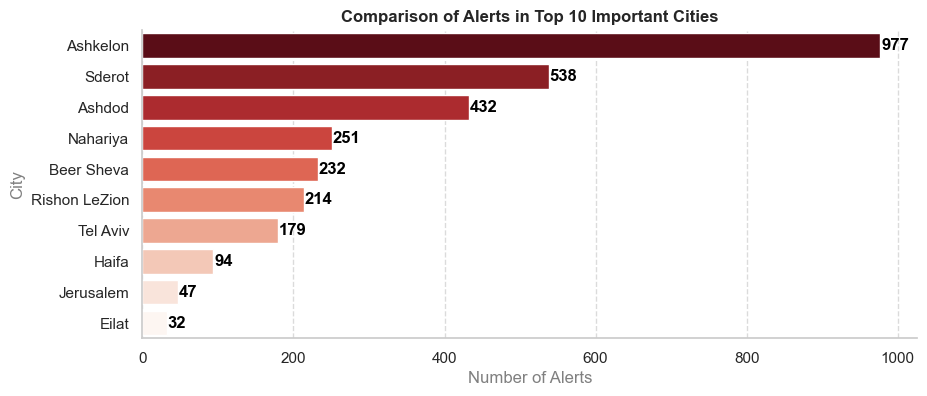

In [43]:
top_10_cities_list = [
    "Tel Aviv", "Jerusalem", "Haifa", "Beer Sheva", "Rishon LeZion",
    "Ashdod", "Ashkelon", "Sderot", "Nahariya", "Eilat"
]

# Filter the DataFrame to include only the top 10 cities
top_10_cities = df[df['locality'].isin(top_10_cities_list)]

# Count alerts by city
alerts_by_top_10_cities = top_10_cities['locality'].value_counts().reset_index()
alerts_by_top_10_cities.columns = ['City', 'Number of Alerts']

# Sort by the number of alerts in descending order
alerts_by_top_10_cities = alerts_by_top_10_cities.sort_values(
    by='Number of Alerts', ascending=False)

# Plot the comparison
plt.figure(figsize=(10, 4))
sns.barplot(data=alerts_by_top_10_cities, x="Number of Alerts", y="City", 
            hue=alerts_by_top_10_cities.index, palette="Reds_r", legend=False)

# Add labels
plt.title("Comparison of Alerts in Top 10 Important Cities", 
          fontweight='bold')
plt.xlabel("Number of Alerts", color='gray')
plt.ylabel("City", color='gray')

# Show numbers on bars
for index, value in enumerate(alerts_by_top_10_cities["Number of Alerts"]):
    plt.text(value + 1, index, str(value), ha="left", va="center", 
             fontweight="bold", fontsize=12, color="black")

plt.grid(axis='x', linestyle="--", alpha=0.7)
sns.despine()
plt.show()


Now let's build a graph by year.

**Color Selection Logic:**
- South – Yellow to orange-red, distinct per city.
- North – Cool blue-gray, contrasting the warm south.
- Center – Red shades, with Tel Aviv brighter than Rishon LeZion.
- Jerusalem – Deep purple, emphasizing uniqueness.

In [44]:
city_colors = {
    "Tel Aviv":      "#C81E28",  # Bright red (central region)
    "Jerusalem":     "#6F2C6B",  # Deep purple (stands out)
    "Haifa":         "#4F7298",  # Cool medium blue (north)
    "Beer Sheva":    "#E07A29",  # Warm brownish-orange (south)
    "Rishon LeZion": "#A60D20",  # Dark red (central region), but lighter than Tel Aviv
    "Ashdod":        "#F16E43",  # Orange with a reddish undertone (south)
    "Ashkelon":      "#FF9642",  # Light orange (south)
    "Sderot":        "#FFCA28",  # Bright golden (south)
    "Nahariya": "#3B5E70",  # Dark grayish-blue (north)
    "Eilat":         "#FF3D2E"   # Rich orange-red (resort city, stands out)
}



# 1) Group by (year, locality) and pivot so each row is a year and each column is a city
alerts_by_city_year = top_10_cities.groupby(
    [top_10_cities['datetime'].dt.year, 'locality']
).size().unstack(fill_value=0)

# 2) Exclude years 2018 and 2025
alerts_by_city_year = alerts_by_city_year.loc[
    (alerts_by_city_year.index != 2018) & (alerts_by_city_year.index != 2025)
]

# 3) Convert pivot to "long" form: columns -> (year, city, alerts)
df_melted = alerts_by_city_year.reset_index().melt(
    id_vars='datetime',  # pivot index (year) was named 'datetime' after reset_index
    var_name='city',
    value_name='alerts'
)

df_melted.rename(columns={'datetime': 'year'}, inplace=True)  # rename for clarity


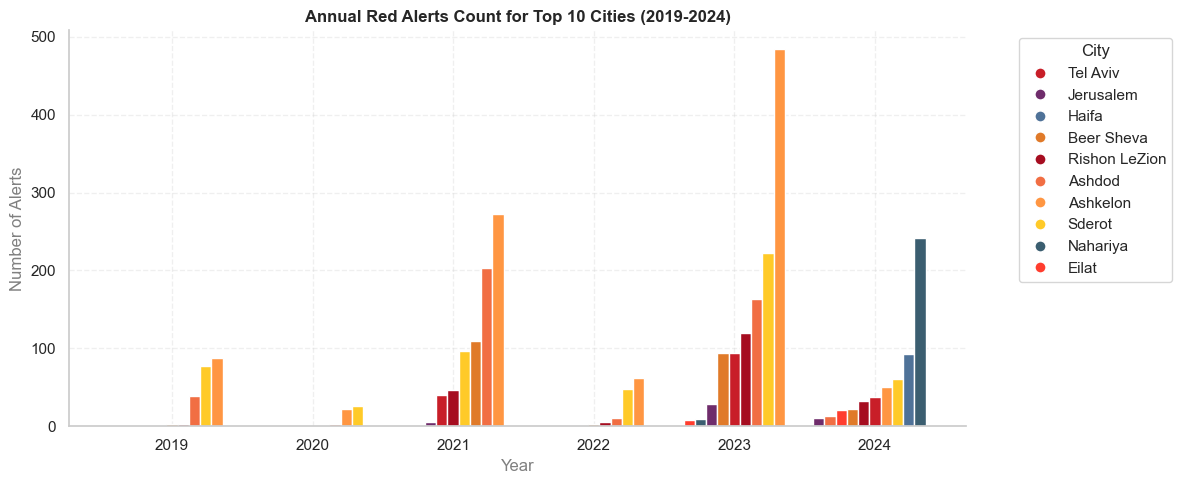

In [45]:
# Sort the years in ascending order
years = sorted(df_melted['year'].unique())

plt.figure(figsize=(12, 5))

# Define how wide each entire group will be on the x-axis
group_width = 0.8  
# We'll place each year's group center at x = i (i.e., 0, 1, 2, ...)

for i, year in enumerate(years):
    # Subset for this year
    sub = df_melted[df_melted['year'] == year].copy()
    # Sort the subset by alerts ascending
    sub.sort_values(by='alerts', inplace=True)
    
    # Now we have N cities for this year
    n = len(sub)
    # We'll place these bars in [i - group_width/2, i + group_width/2]
    # So each bar has width = group_width / n
    bar_width = group_width / n
    
    # Left edge for the first bar in this group
    left_edge = i - group_width/2
    
    # Plot each city’s bar
    for j, row in enumerate(sub.itertuples()):
        city = row.city
        alerts = row.alerts
        
        # X-position for this bar
        x_bar = left_edge + j * bar_width
        
        # Get the color for this city
        color = city_colors.get(city, 'gray')
        
        # Draw the bar
        plt.bar(x_bar, alerts, width=bar_width, color=color)
        

# X-axis: put tick marks at each integer i, label them by the year
plt.xticks(range(len(years)), years)

plt.xlabel("Year", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Annual Red Alerts Count for Top 10 Cities (2019-2024)", 
          fontweight='bold')

# Create a custom legend so each city retains the same color

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=city, 
           markerfacecolor=color, markersize=8) 
    for city, color in city_colors.items() 
    if city in df_melted['city'].unique()
]

plt.legend(
    handles=legend_elements,
    title="City",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Light dashed grid
plt.grid(axis='both', linestyle='--', alpha=0.3)

sns.despine()
plt.tight_layout()
plt.show()


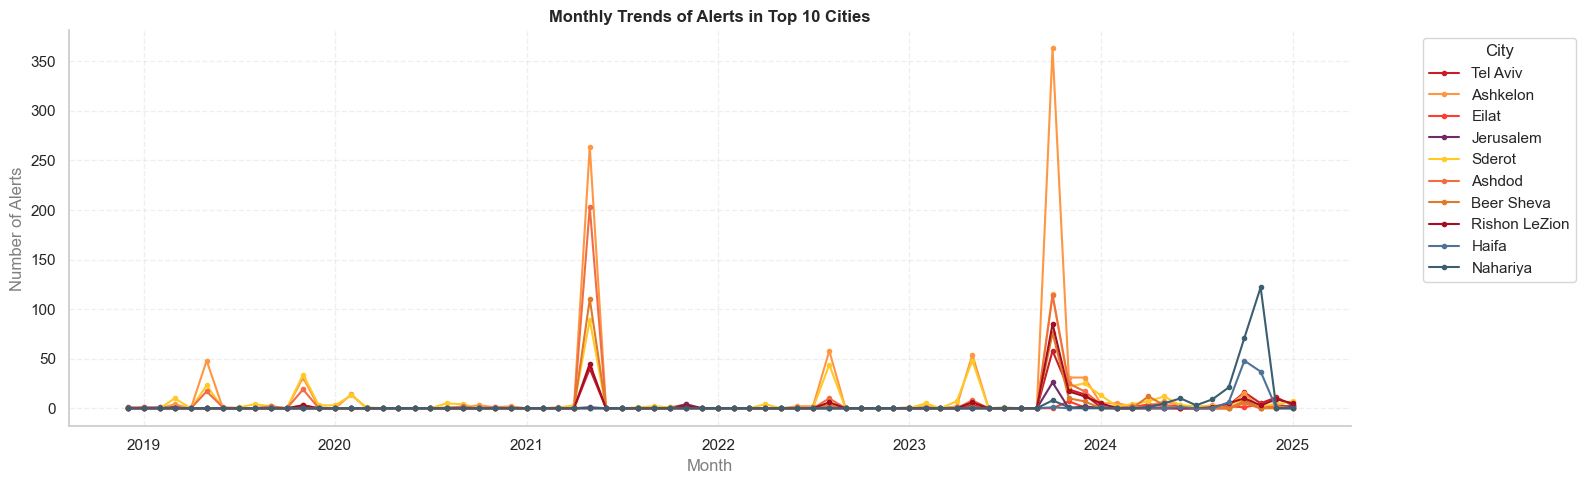

In [46]:
# Group data by month and city, counting the number of alerts
alerts_by_month_city = top_10_cities.groupby(
    [top_10_cities['datetime'].dt.to_period('M'), 'locality']
).size().reset_index()

alerts_by_month_city.columns = ['Month', 'City', 'Number of Alerts']
alerts_by_month_city['Month'] = alerts_by_month_city['Month'].astype(str)

# Convert 'Month' to datetime format (fixing the Period issue)
alerts_by_month_city['Month_dt'] = pd.to_datetime(alerts_by_month_city['Month'])

# Create a complete dataset with all month-city combinations
all_months = pd.date_range(
    start=alerts_by_month_city['Month_dt'].min(),
    end=alerts_by_month_city['Month_dt'].max(),
    freq='MS'  # 'MS' ensures we generate the start of each month
)

all_cities = alerts_by_month_city['City'].unique()

# Create a full dataframe with all possible month-city combinations
all_combinations = pd.DataFrame([(m, c) 
                                 for m in all_months for c in all_cities], 
                                columns=['Month_dt', 'City'])

# Merge with the original data and fill missing values with 0
alerts_by_month_city = all_combinations.merge(alerts_by_month_city, 
                                              on=['Month_dt', 'City'], 
                                              how='left'
                                             ).fillna(0)

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the figure and axis
plt.figure(figsize=(16, 5))
ax = plt.gca()


# Plot each city on the same axes
for city in alerts_by_month_city['City'].unique():
    city_data = alerts_by_month_city[alerts_by_month_city['City'] == city]
    plt.plot(
        city_data['Month_dt'],  # Now it's a proper datetime format
        city_data['Number of Alerts'],
        marker='o',
        markersize=3,                # Make markers smaller
        linewidth=1.5,               # Slightly thinner line
        color=city_colors.get(city, 'gray'),
        label=city
    )

# Axis labels and title
plt.xlabel("Month", color='gray')
plt.ylabel("Number of Alerts", color='gray')
plt.title("Monthly Trends of Alerts in Top 10 Cities", 
          fontweight='bold')

# Use AutoDateLocator and ConciseDateFormatter to space out and format date labels
locator = mdates.AutoDateLocator(minticks=3, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Rotate x-axis labels for readability
plt.xticks(rotation=0)

# Legend and grid
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.3)

# Automatically adjust layout for a cleaner look
sns.despine()
plt.tight_layout()
plt.show()


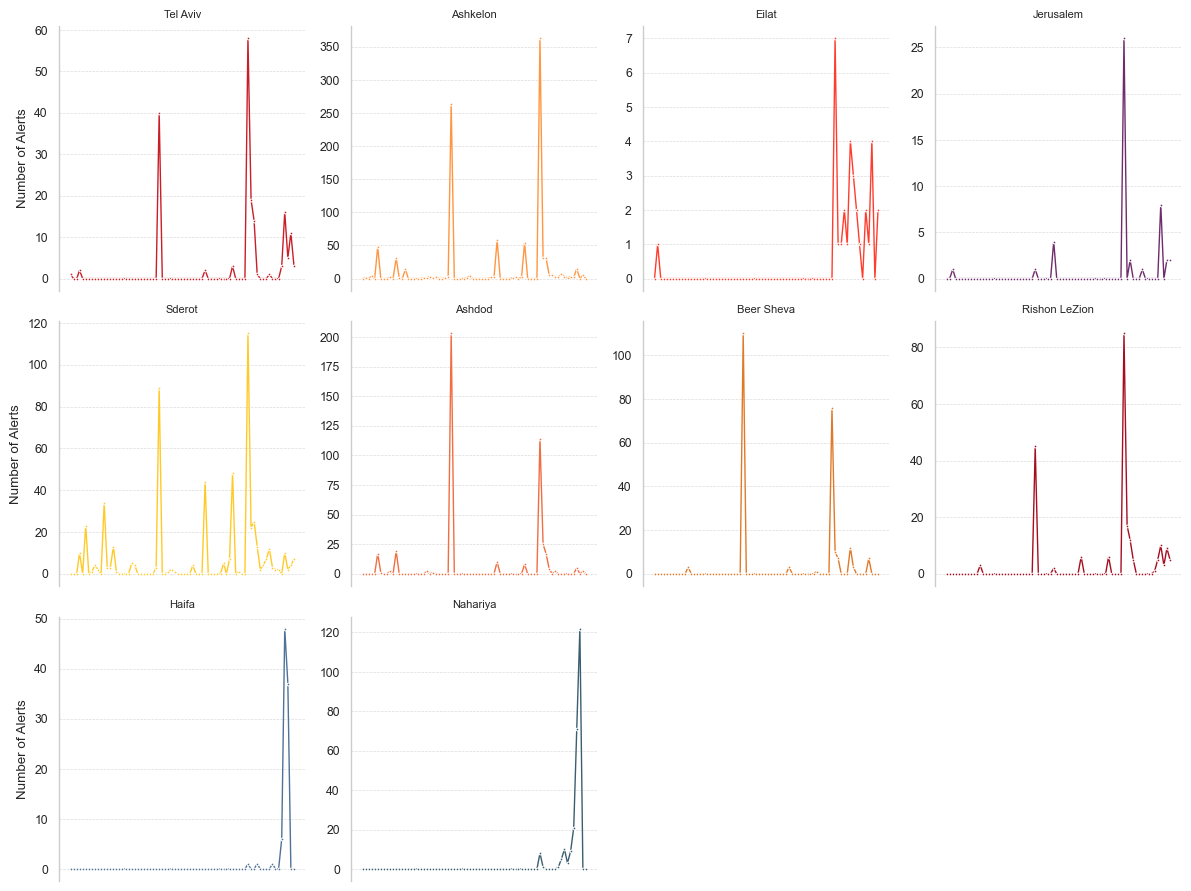

In [47]:
# Set Seaborn style & smaller context for compact visuals
sns.set_style("whitegrid")
sns.set_context("paper")  # Small font sizes for a cleaner look

# Custom function to plot each facet with the city-specific color
def plot_with_city_color(data, **kwargs):
    city_name = data['City'].iloc[0]
    color = city_colors.get(city_name, "gray")
    kwargs.pop("color", None)  # Avoid conflicts with automatic coloring
    
    sns.lineplot(
        data=data,
        x='Month_dt',
        y='Number of Alerts',
        marker='o',
        markersize=2,  # Smaller markers for a more delicate look
        linewidth=1,  # Thinner lines for a clean appearance
        color=color,
        **kwargs
    )

# Create a FacetGrid with smaller subplots
g = sns.FacetGrid(
    alerts_by_month_city,
    col="City",
    col_wrap=4,  # More cities in one row for better alignment
    height=3,  # Smaller subplots
    sharey=False,
    sharex=False
)

# Map our custom function to the FacetGrid
g.map_dataframe(plot_with_city_color)

# Titles: city names in smaller font
g.set_titles("{col_name}", size=8)

# Y-axis label remains, X-axis labels are removed
g.set_axis_labels("", "Number of Alerts")

# Remove x-axis ticks & labels to keep it clean
for ax in g.axes.flatten():
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel(None)
    
    # Set **dashed grid lines**
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  
    
    sns.despine(ax=ax, left=False, bottom=True)  

# Adjust layout to avoid overlaps
plt.tight_layout()
plt.show()


In [48]:
# Print the alerts count for each city per year
alerts_by_city_year

locality,Ashdod,Ashkelon,Beer Sheva,Eilat,Haifa,Jerusalem,Nahariya,Rishon LeZion,Sderot,Tel Aviv
datetime,,,,,,,,,,
2019,39,87,3,1,0,1,0,3,77,2
2020,3,22,0,0,0,0,0,0,26,0
2021,203,272,110,0,0,5,0,47,96,40
2022,10,62,3,0,0,0,0,6,48,2
2023,164,484,94,8,1,28,9,120,223,94
2024,13,50,22,21,93,11,242,33,61,37


- **Ashkelon & Sderot are the most affected** – Ashkelon recorded the highest number of alerts in 2023 (484), while Sderot showed consistently high numbers across all years.
- **Significant spikes in 2021 and 2023** – Cities like Ashdod, Beer Sheva, and Tel Aviv experienced major peaks in alerts, aligning with periods of heightened conflict.
- **Kiryat Shmona saw a surge in 2024** – Previously low in alerts, Nahariya recorded **582 alerts** in 2024, a sharp increase compared to previous years.
- **Eilat & Haifa had minimal activity until 2024** – Eilat had almost no alerts before 2023 but recorded **21 in 2024**, while Haifa jumped from near-zero to **93 in 2024**.
- **Jerusalem & Rishon LeZion had moderate fluctuations** – Both cities experienced occasional spikes but remained relatively lower than Ashkelon and Sderot.

---

🔍 **Key Insights:**
- The data indicates **a strong geographical pattern**, with southern cities (Ashkelon, Sderot, and Ashdod) being the most affected.
- **2023 and 2024 stand out as years with heightened alert activity**, possibly due to escalated regional tensions.
- The **increase in alerts in northern cities (Haifa, kiryat Shmona) in 2024** suggests a shift in threat distribution.


### Conclusion

The analysis reveals a strong geographical pattern and an evolving threat landscape over time. Initially, before **October 7, 2023**, the highest alert counts were concentrated in southern cities—such as **Ashkelon (502 alerts)**, **Netiv HaAsara (318 alerts)**, and **Sderot (308 alerts)**—indicating persistent threats from the Gaza Strip. After the onset of the war, a dramatic shift occurred: northern localities like **Kiryat Shmona (582 alerts)**, **Margaliot (425 alerts)**, and **Misgav Am (403 alerts)** became the primary targets, suggesting an escalation of hostilities near the Lebanese border. Despite this shift, **Ashkelon (475 alerts)** remained the most targeted city in the south.


Furthermore, the data highlights stark contrasts in security risks. The **most affected city overall** was **Ashkelon (977 alerts)**, followed by **Kiryat Shmona (583 alerts)** and **Sderot (538 alerts)**. Conversely, cities like **Tiberias (22 alerts)**, **Netanya (21 alerts)**, and **Ariel (9 alerts)** experienced the fewest alerts, showing a much lower level of threat—sometimes over **60 times fewer alerts** than the most impacted areas.


The **top-10 cities** analysis underscores these differences, with consistent high counts in cities like **Ashkelon and Sderot**, major spikes during key conflict periods (**2021, 2023, and 2024**), and a significant increase in alerts for northern cities like **Kiryat Shmona (582 alerts in 2024)**. Additionally, previously low-activity cities, such as **Eilat (21 alerts in 2024)** and **Haifa (93 alerts in 2024)**, saw an increase in threats, reflecting the expanding reach of hostilities.

---

🔍 **Key Insight:**

The conflict has significantly reshaped the security landscape, shifting the primary threat from the south to the north. While **Ashkelon** remains the most targeted city, the **rise in alerts in Kiryat Shmona and Nahariya** underscores a growing northern threat. Meanwhile, some central cities have seen minimal activity.



## 🚀 Types of Alarms

This section focuses on analyzing the different types of alarms recorded in the datasets. We will explore overall counts, temporal trends, and spatial distributions to gain insights into the alarm patterns.

### General Statistics

In [49]:
# Since 'Interception pieces' appears only once and does not repeat anywhere else, 
# it could be related to either 'Red Alert' or 'Unrecognized Aircraft'.
# For simplicity, we will rename it to 'Red Alert'.

detailed_df['threat_type'] = detailed_df['threat_type'].replace('Interception pieces', 'Red Alert')

In [50]:
# Count the number of alarms per threat type
alarm_counts = detailed_df['threat_type'].value_counts()
alarm_counts.to_frame()

,count
threat_type,
Red Alert,52919
Unrecognized Aircraft,7727
Earthquake,561
Terrorist Infiltration,74


In [51]:
# Calculate percentages
alarm_percentage = (alarm_counts / alarm_counts.sum()) * 100
alarm_percentage_formatted = alarm_percentage.map(lambda x: f"{x:.2f}%")

# Display the formatted percentages
print("Alarm Type Percentages")
alarm_percentage_formatted.to_frame()

Alarm Type Percentages


,count
threat_type,
Red Alert,86.35%
Unrecognized Aircraft,12.61%
Earthquake,0.92%
Terrorist Infiltration,0.12%


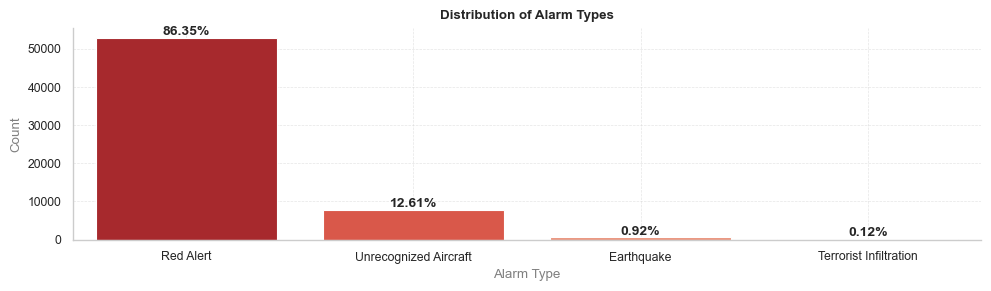

In [52]:
# Create the bar chart
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=alarm_counts.index, y=alarm_counts.values, 
                 hue=alarm_counts.index, palette="Reds_r", legend=False)

# Add percentage labels on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f"{alarm_percentage_formatted.iloc[i]}",  # Use iloc for positional indexing
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add dashed, thin, semi-transparent grid lines
ax.grid(True, which='major', linestyle='dashed', linewidth=0.5, alpha=0.5)

# Set titles and labels
plt.title("Distribution of Alarm Types", fontweight='bold')
plt.xlabel("Alarm Type", color='gray')
plt.ylabel("Count", color='gray')
plt.xticks(rotation=0)

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()

The vast majority of alarms **(52919 or 86.35%)** were triggered by **Red Alerts**, indicating a high frequency of missile threats. **Unrecognized Aircraft** accounted for **7727 or 12.61%**, suggesting occasional unidentified aerial activity. **Earthquakes** and **Terrorist Infiltrations** were rare, making up **561 (0.92%)** and **77 (0.12%)**, respectively.  

### Temporal Dynamics
We will explore the time evolution of each alarm type to identify trends and potential seasonal patterns.

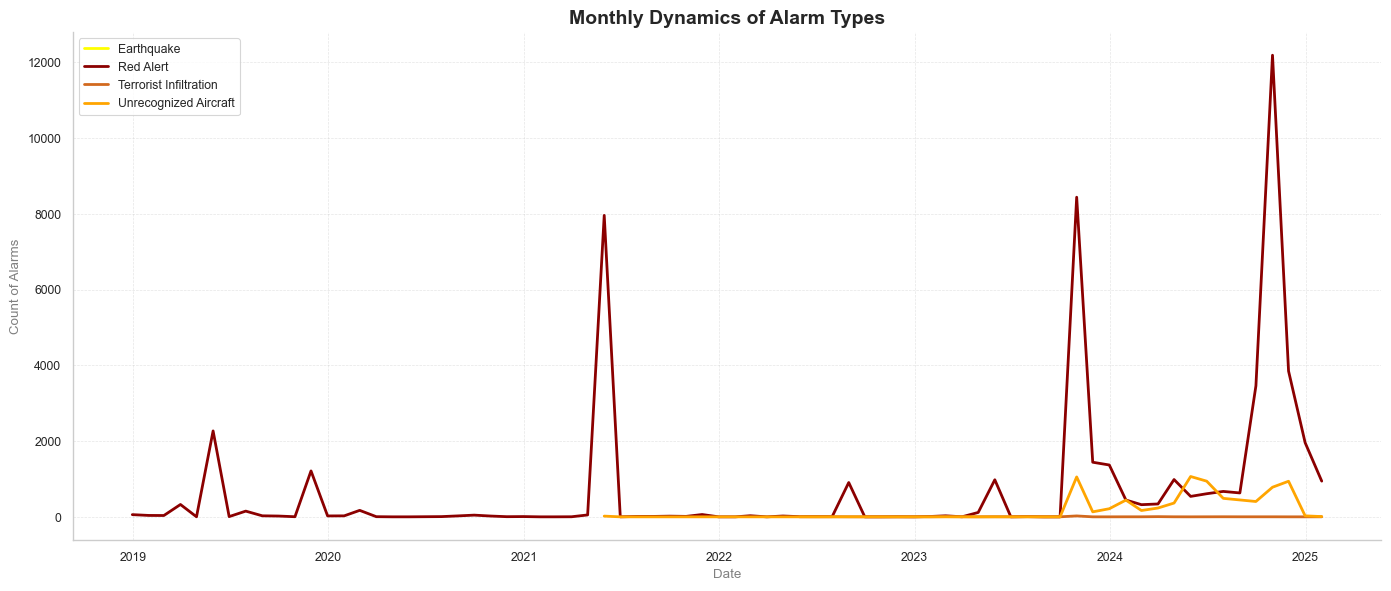

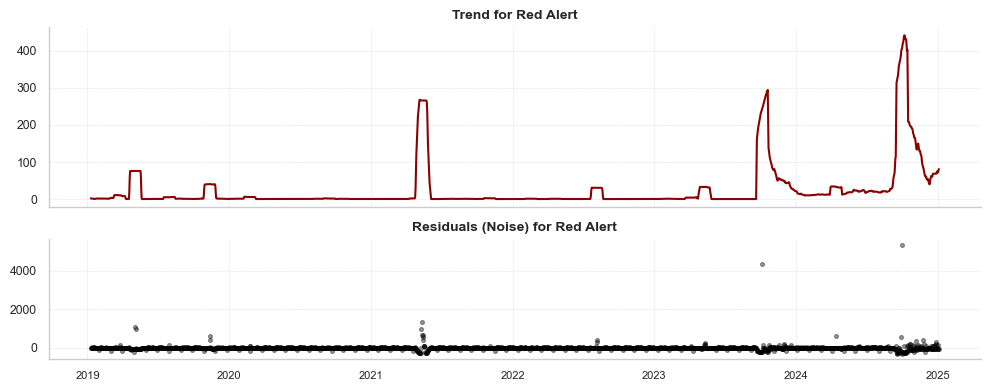

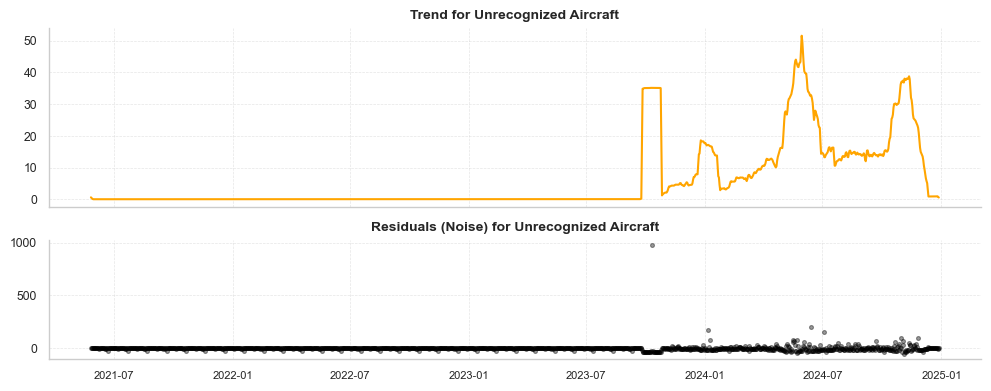

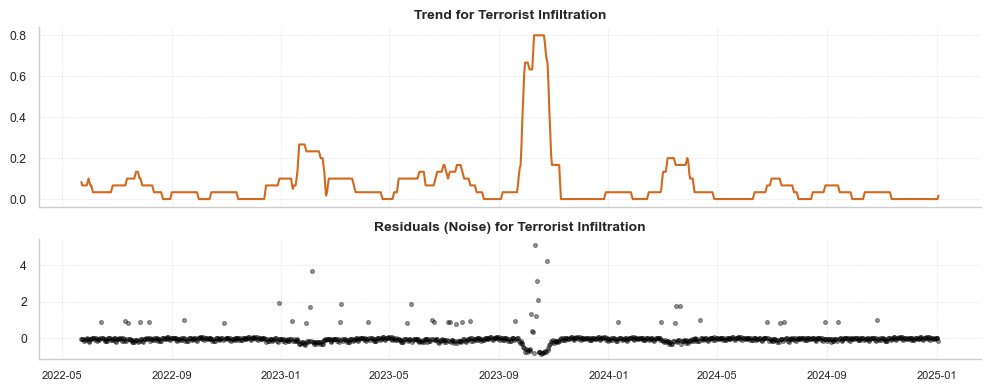

In [53]:
# Define custom colors for each threat type
threat_colors = {
    "Red Alert": "darkred",
    "Unrecognized Aircraft": "orange",
    "Terrorist Infiltration": "chocolate",
    "Earthquake": "yellow",
}

# Ensure 'datetime' column is in datetime format and set it as index
detailed_df["datetime"] = pd.to_datetime(detailed_df["datetime"])
detailed_df = detailed_df.set_index("datetime")

# Aggregate alarms by month and count occurrences
monthly_counts = (
    detailed_df.groupby("threat_type")
    .resample("ME")
    .size()
    .reset_index(name="count")
)

# ---- Plot Monthly Dynamics of Alarm Types ---- #
plt.figure(figsize=(14, 6))

# Plot each threat type with its respective color
for threat in monthly_counts["threat_type"].unique():
    threat_data = monthly_counts[monthly_counts["threat_type"] == threat]
    
    plt.plot(
        threat_data["datetime"],
        threat_data["count"],
        label=threat,
        linewidth=2,
        color=threat_colors.get(threat, "gray"),  # Use gray if threat type is missing in dictionary
    )

# Configure plot aesthetics
plt.title("Monthly Dynamics of Alarm Types", size=14, fontweight="bold")
plt.xlabel("Date", color='gray')
plt.ylabel("Count of Alarms", color='gray')
plt.legend()
plt.grid(True, linestyle="dashed", linewidth=0.5, alpha=0.5)

# Display the plot
sns.despine()
plt.tight_layout()
plt.show()

# ---- Perform Seasonal Decomposition ---- #
for threat in detailed_df["threat_type"].unique():
    # Resample data to daily frequency
    threat_series = (
        detailed_df[detailed_df["threat_type"] == threat]
        .resample("D")
        .size()
    )

    # Ensure there are enough data points for decomposition
    if len(threat_series) >= 60:
        decomposition = seasonal_decompose(threat_series, model="additive", period=30)

        # Create subplot structure: trend (larger) and residuals (smaller)
        fig, axes = plt.subplots(
            2, 1, figsize=(10, 4), sharex=True, gridspec_kw={"height_ratios": [1.5, 1]}
        )

        # ---- Trend Plot ---- #
        axes[0].plot(
            decomposition.trend, 
            color=threat_colors.get(threat, "gray"), 
            linewidth=1.5
        )
        axes[0].set_title(f"Trend for {threat}", fontsize=10, fontweight="bold")
        axes[0].grid(True, linestyle="dashed", linewidth=0.5, alpha=0.5)

        # ---- Residuals (Noise) Plot ---- #
        axes[1].scatter(
            decomposition.resid.index,
            decomposition.resid,
            color="black",
            alpha=0.4,
            s=8,
        )
        axes[1].set_title(f"Residuals (Noise) for {threat}", fontsize=10, 
                          fontweight='bold')
        axes[1].grid(True, linestyle="dashed", linewidth=0.5, alpha=0.5)

        # Improve x-axis readability
        for ax in axes:
            ax.tick_params(axis="x", rotation=0, labelsize=8)

        # Remove unnecessary plot borders
        sns.despine()
        plt.tight_layout()

        # Display the plot
        plt.show()


In [54]:
# Filtering data on the Earthquake threat
earthquake_df = detailed_df[detailed_df['threat_type'] == 'Earthquake']

# Counting the number of earthquakes by date
earthquake_df['date'].value_counts()

date
2024-10-26    561
Name: count, dtype: int64

In [55]:
# Getting a list of unique districts and regions
earthquake_df[['district', 'region']].drop_duplicates()

,district,region
datetime,,
2024-10-26 07:02:45,Northern District,Beit She'an Valley
2024-10-26 07:02:47,Haifa District,HaMifratz
2024-10-26 07:02:47,Northern District,HaAmakim
2024-10-26 07:02:47,Northern District,Upper Galilee
2024-10-26 07:02:47,Haifa District,HaCarmel
2024-10-26 07:02:47,Northern District,South Golan
2024-10-26 07:02:47,Northern District,Center Galilee
2024-10-26 07:02:47,Northern District,Lower Galilee
2024-10-26 07:02:48,Haifa District,Menashe


The earthquake warning was activated 1 time on 2024-10-26 mainly in the Northern and Haifa Districts (in the north of the country).  It was a false alarm.

In [56]:
# Counting the number of Unrecognized Aircrafts warnings by date
detailed_df[detailed_df['threat_type'] == 'Unrecognized Aircraft']['date'].value_counts()

date
2023-10-11    1038
2024-06-13     240
2024-01-06     199
2024-07-04     172
2024-10-30     139
              ... 
2022-08-06       1
2024-08-17       1
2024-09-04       1
2025-01-01       1
2025-01-09       1
Name: count, Length: 271, dtype: int64

The maximum number of alarms was 2023-10-11 (1038). It was a false alarm.

In [57]:
# Counting the number of earthquakes by date
detailed_df[detailed_df['threat_type'] == 'Terrorist Infiltration']['date'].value_counts().head(5)


date
2023-10-11    6
2023-10-24    5
2023-10-13    4
2023-02-04    4
2023-10-14    3
Name: count, dtype: int64

The maximum number of warnings about terrorist infiltration is 6, which occurred October 11 2023.

---

- **Red Alert** remains the most frequent alarm, showing major spikes during critical escalation periods.  
- **Unrecognized Aircraft** start appearing prominently around **October 7, 2023**, suggesting intensified UAV usage from the onset of the war.  
- **Terrorist Infiltration** is generally sporadic yet shows a surge at the beginning of the conflict on **October 7, 2023**, indicating a large-scale infiltration event.  
- **Earthquakes** warning was activated 1 time and was a false alarm.

---

🔍 **Key Insights:**

The data clearly illustrates how the war on **October 7, 2023**, triggered a sharp rise in **drone-related (Unrecognized Aircraft) incidents** and **Terrorist Infiltrations**, overshadowing other alarm types and reinforcing the dominance of **Red Alert** events.

### Spatial Distribution

We will visualize the distribution of alarm types across different localities (cities) and identify local anomalies, such as areas with a high frequency of "Unrecognized Aircraft" warnings.

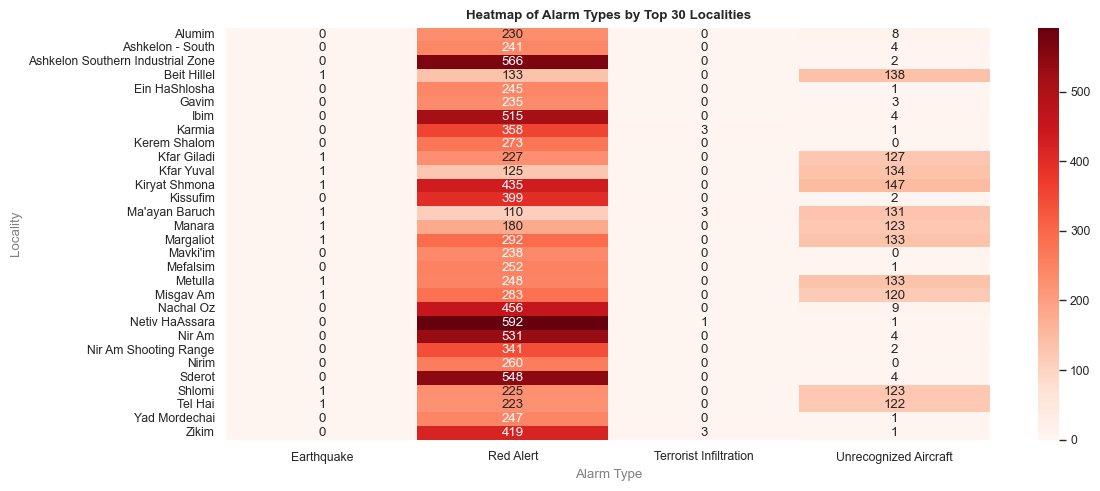

In [58]:
# Get the top 30 localities by total alarm count
top_30_localities = (detailed_df['locality']
                  .value_counts()
                  .head(30)
                  .index)

# Filter the DataFrame to include only those localities
filtered_top_30_df = detailed_df[detailed_df['locality'].isin(top_30_localities)]

# Create a pivot table: rows = localities, columns = threat types
heatmap_data = filtered_top_30_df.groupby(['locality', 'threat_type']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, 
            annot=True,     
            fmt='d', 
            cmap='Reds')  # Change colormap to 'Reds'
plt.title("Heatmap of Alarm Types by Top 30 Localities", fontweight='bold')
plt.xlabel("Alarm Type", color='gray')
plt.ylabel("Locality", color='gray')
plt.tight_layout()
plt.show()



Red Alert dominates in nearly all top localities.
Some localities show extremely high counts of Red Alerts: **Nahal Oz** (545), **Zikim** (538), **Nir Am Shooting Range** (501).
Earthquakes, Terrorist Infiltrations, and Unrecognized Aircraft are relatively rare among these localities, typically ranging from 0 to a few events.

In [59]:
# Group by district and threat_type, then pivot
district_threat = detailed_df.groupby(['district', 'threat_type']).size().unstack(fill_value=0)

# Inspect the pivot table
district_threat


threat_type,Earthquake,Red Alert,Terrorist Infiltration,Unrecognized Aircraft
district,,,,
Central District,0,9379,6,24
Haifa District,99,2173,0,282
Jerusalem District,0,410,0,0
Judea and Samaria Area,5,2866,54,0
Northern District,369,6712,0,2320
Southern District,88,29365,14,5091
Tel Aviv District,0,2014,0,10


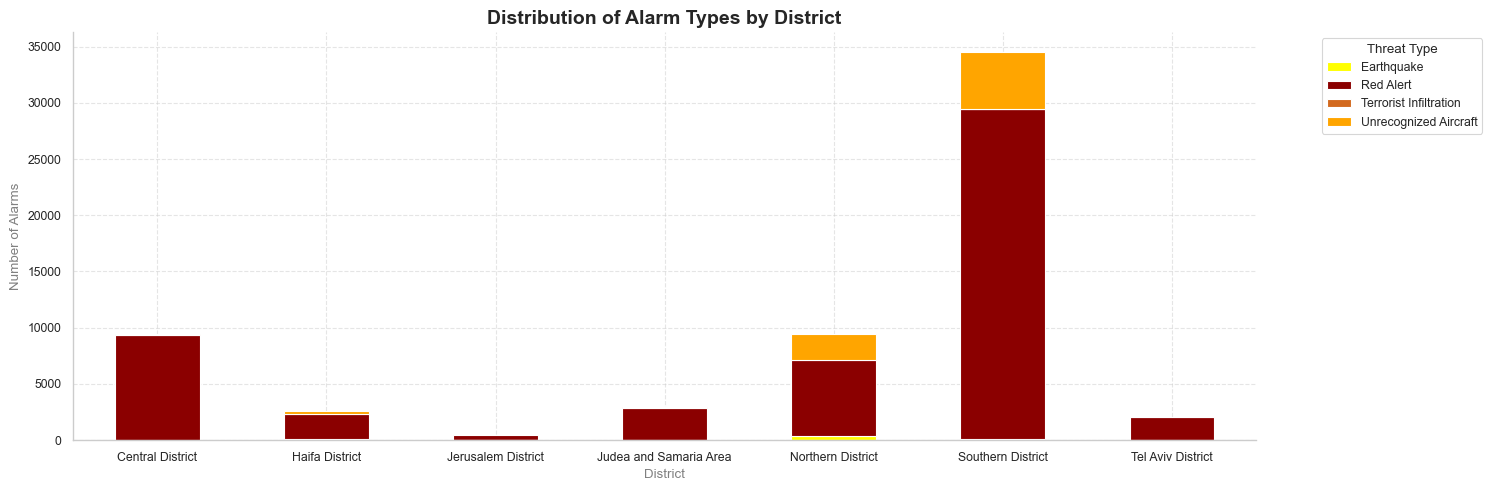

In [60]:
# Define colors in the order corresponding to district_threat columns
column_colors = [threat_colors.get(col, "gray") for col in district_threat.columns]

# Plot a stacked bar chart with custom colors
ax = district_threat.plot(kind='bar', stacked=True, figsize=(15, 5), color=column_colors)

# Title and labels
plt.title("Distribution of Alarm Types by District", size=14, fontweight='bold')
plt.xlabel("District", color='gray')
plt.ylabel("Number of Alarms", color='gray')

# Move the legend outside for clarity
plt.legend(title="Threat Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Customize grid: make it dashed and semi-transparent
ax.grid(visible=True, linestyle='dashed', alpha=0.5)

# Remove unnecessary spines for a cleaner look
sns.despine()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


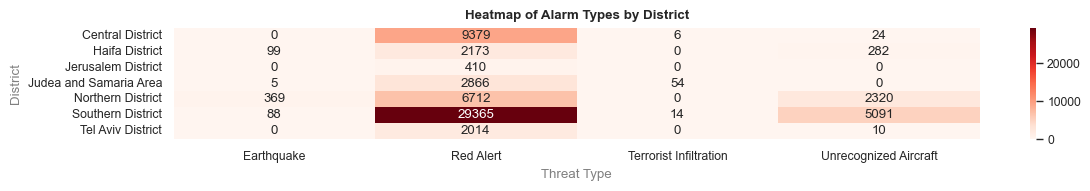

In [61]:
plt.figure(figsize=(12, 2))
sns.heatmap(district_threat, annot=True, fmt='d', cmap='Reds')
plt.title("Heatmap of Alarm Types by District", fontweight='bold')
plt.xlabel("Threat Type", color='gray')
plt.ylabel("District", color='gray')
plt.tight_layout()
plt.show()


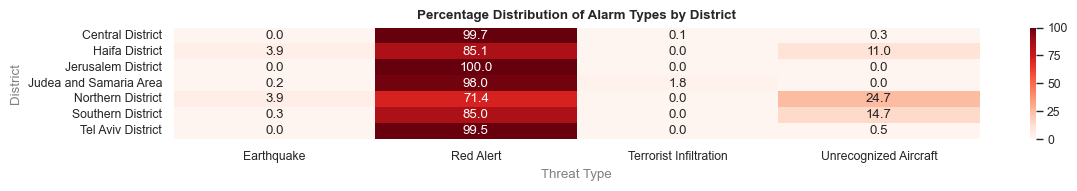

In [62]:
district_threat_perc = district_threat.apply(lambda row: row / row.sum(), axis=1) * 100

plt.figure(figsize=(12, 2))
sns.heatmap(district_threat_perc, annot=True, fmt=".1f", cmap='Reds')
plt.title("Percentage Distribution of Alarm Types by District", fontweight='bold')
plt.xlabel("Threat Type", color='gray')
plt.ylabel("District", color='gray')
plt.tight_layout()
plt.show()


In [63]:
district_threat_perc

threat_type,Earthquake,Red Alert,Terrorist Infiltration,Unrecognized Aircraft
district,,,,
Central District,0.000000,99.681156,0.063769,0.255075
Haifa District,3.876273,85.082224,0.000000,11.041504
Jerusalem District,0.000000,100.000000,0.000000,0.000000
Judea and Samaria Area,0.170940,97.982906,1.846154,0.000000
Northern District,3.925114,71.396660,0.000000,24.678226
Southern District,0.254644,84.973089,0.040512,14.731755
Tel Aviv District,0.000000,99.505929,0.000000,0.494071


- **Red Alert** dominates most districts:
  - Southern District has **29,365** Red Alerts (**84.97%** of its alarms).  
  - Jerusalem District is **100%** Red Alerts (**410** total).  
  - Tel Aviv District is **99.51%** Red Alerts (**2,014** out of **2,024**).  

- **Southern District** also has **5,091** Unrecognized Aircraft (**14.73%**)—the highest absolute number.

- **Northern District** has **2,320** Unrecognized Aircraft (**24.7%**) and **6,712** Red Alerts (**71.4%**).

- **Judea and Samaria Area** leads in Terrorist Infiltrations with **54** incidents (**1.85%**), while **91.09%** of its alarms are Red Alerts.

- **Jerusalem District** and **Tel Aviv District** remain almost entirely Red Alerts (100% and 99.51%, respectively).

---

🔍 **Key Insight:**

The **Southern District** experiences the highest volume of alarms and the broadest variety of threats, while the **Northern District** faces the most Unrecognized Aircraft incidents. **Judea and Samaria Area** is uniquely affected by Terrorist Infiltrations, whereas **Jerusalem and Tel Aviv Districts** show a uniform threat profile dominated solely by Red Alerts.

### Conclusion  

The data reveals that **missile threats (Red Alerts) overwhelmingly dominate the alarm system**, accounting for **86.35% (52,919 alerts)**. Other alarm types, such as **Unrecognized Aircraft (12.61%, 7,727 alerts)**, **Earthquakes (0.92%, 561 alerts)**, and **Terrorist Infiltrations (0.12%, 77 alerts)**, remain significantly lower in frequency. However, their patterns highlight key shifts in the conflict landscape.

The **October 7, 2023, war onset** marked a sharp increase in **Unrecognized Aircraft incidents**—a reflection of intensified drone usage. Simultaneously, **Terrorist Infiltration alerts surged**, correlating with large-scale incursions into Israeli territory. Meanwhile, **the single Earthquake alert was a false alarm**, showing its minimal relevance in the dataset.

**Spatial Patterns of Alarms**
- **Southern District** recorded **29,365 Red Alerts (84.97%)**, the highest number of missile threats. It also experienced **5,091 Unrecognized Aircraft incidents (14.73%)**, making it the **most diverse in alarm types**.  
- **Northern District** had **6,712 Red Alerts (71.4%)** but stood out for **2,320 Unrecognized Aircraft alerts (24.7%)**, indicating a higher UAV presence.  
- **Judea and Samaria Area** led in **Terrorist Infiltrations (54 incidents, 1.85%)**, reinforcing its unique security challenges.  
- **Jerusalem (100%) and Tel Aviv (99.51%) districts** had nearly **exclusive Red Alerts**, highlighting their missile-focused threat landscape.  

---

🔍 **Key Insight:**  

The **Southern District** remains the most impacted by a wide range of threats, with **frequent Red Alerts and drone activity**. In contrast, **Northern Israel faces a growing UAV threat**, while **Judea and Samaria Area experiences the highest number of infiltration incidents**. Despite their strategic importance, **Jerusalem and Tel Aviv remain primarily missile targets**, with minimal diversity in threat types.


## 🗺️ Geospatial Analysis

### By districts

In [64]:
# 1. Counting Alerts by Districts
alerts_by_district = detailed_df['district'].value_counts().reset_index()
alerts_by_district.columns = ['district', 'count']
print("Alerts count by district:")


alerts_by_district

Alerts count by district:


,district,count
0,Southern District,34558
1,Central District,9409
2,Northern District,9401
3,Judea and Samaria Area,2925
4,Haifa District,2554
5,Tel Aviv District,2024
6,Jerusalem District,410


In [65]:
# Path to the GeoJSON file
state_geo = r'C:\Users\Vera\Documents\DA Practicum\work files\geoBoundaries-ISR-ADM1-all\geoBoundaries-ISR-ADM1.geojson'

# Load GeoJSON
with open(state_geo, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Display all available district names in GeoJSON
geojson_names = [feat["properties"]["shapeName"] for feat in data["features"]]
print("District names in GeoJSON:", geojson_names)

# Extract unique district names from alerts data
alerts_names = alerts_by_district["district"].unique()
print("District names in alerts_by_district:", alerts_names)

# Rename dictionary for district names
rename_districts = {
    'Southern District': 'Southern District',
    'Central District': 'Central District',
    'Northern District': 'Northern District',
    'Judea and Samaria Area': 'Judea and Samaria Area',  
    'Haifa': 'Haifa District',
    'Tel Aviv': 'Tel Aviv District',
    'Jerusalem District': 'Jerusalem District'
}

# Rename shapeName in GeoJSON
for feature in data["features"]:
    old_name = feature["properties"]["shapeName"]
    if old_name in rename_districts:
        feature["properties"]["shapeName"] = rename_districts[old_name]
    else:
        print(f"⚠️ No match found for {old_name}")

# Save the updated GeoJSON
updated_geojson_path = "updated_israel_districts.geojson"

with open(updated_geojson_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print(f"✅ Updated GeoJSON saved to {updated_geojson_path}")


District names in GeoJSON: ['Southern District', 'Central District', 'Jerusalem District', 'Tel Aviv', 'Haifa', 'Northern District']
District names in alerts_by_district: ['Southern District' 'Central District' 'Northern District'
 'Judea and Samaria Area' 'Haifa District' 'Tel Aviv District'
 'Jerusalem District']
✅ Updated GeoJSON saved to updated_israel_districts.geojson


In [66]:
# Create a map centered on Israel
m = folium.Map(location=[31.0461, 34.8516], zoom_start=8, tiles='Cartodb Positron')

# Create a choropleth map
choropleth = folium.Choropleth(
    geo_data=updated_geojson_path,  # Using the updated file
    data=alerts_by_district,
    columns=['district', 'count'],
    key_on='feature.properties.shapeName',  # Must match GeoJSON
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Number of Alerts by District'
)

choropleth.add_to(m)

# Save and display the map
m.save("israel_choropleth_map.html")
#m

![Choropleth Map](maps/israel_choropleth_map.png)

The result for the districts is quite approximate due to the large size of the districts, so we will build a heat map for the settlements.

In [67]:
# Initialize geolocator with a user agent and timeout
geolocator = Nominatim(user_agent="my_app", timeout=20)


def get_coordinates(city_name):
    """
    Attempts to retrieve coordinates using Nominatim.
    Appends ', Israel' to improve location accuracy.
    """
    query = f"{city_name}, Israel"
    try:
        location = geolocator.geocode(query, country_codes='il')
        if location:
            return location.latitude, location.longitude
        else:
#            print(f"Coordinates not found for: {city_name}")
            return None, None
    except Exception as e:
        print(f"Error during geocoding {city_name}: {e}")
        return None, None


# Dictionary of manually defined coordinates
manual_coords = {
    "Netiv HaAssara": (31.5708, 34.5394),
    "Nir Am Shooting Range": (31.5185, 34.5805),
    "Metzuba": (33.0633, 35.1583),
    "Kibutz Dan": (33.2403, 35.6531),
    "Nir Yitzhak": (31.23604, 34.356702),
    "Ma'a lot Tarshicha": (33.0167, 35.2708),
    "Be'er Yacov": (31.943507, 34.83904),
    "Ein Yacov": (33.0103, 35.2292),
    "Neveh Ziv": (33.0269, 35.1847),
    "Kannot Industrial Zone": (31.8014, 34.7514),
    "Zichron Yaakov": (32.5708, 34.9517),
    "Gush Etzion Junction": (31.64432, 35.15762),
    "Sha'ar Hanegev Industries": (31.51633, 34.59333),
    "Mevuot Hermon Regional Council": (31.9824446, 34.7651551),
    "Acco - Industrial Zone": (32.92817, 35.07564),
    "Akko New Cemetery": (32.92817, 35.07564),
    "Kiryat Biyalik": (32.8275, 35.0856),
    "Kiryat Bialik Industrial Zone": (32.8275, 35.0856),
    "Kfar Biyalik": (32.8211, 35.0875),
    "Dead Sea Factories": (31.0589, 35.6142),
    "Kiriyat Ono": (32.063599, 34.855301),
    "Netiv HaAssara": (31.5708, 34.5394)
}



In [68]:
def generate_heatmap(alerts_by_city, filename="maps/heatmap.html", zoom=8, radius=15):
    """
    Generates a heatmap from a DataFrame containing a 'locality' column.
    
    Parameters:
        df (DataFrame): The input dataset with a 'locality' column.
        filename (str): The name of the output HTML file.
        zoom (int): Initial zoom level of the map.
        radius (int): Radius of the heatmap points.
    
    Returns:
        folium.Map: The generated map object.
    """

    # Add columns for coordinates
    alerts_by_city['latitude'] = None
    alerts_by_city['longitude'] = None

    # Retrieve coordinates for each locality
    for index, row in alerts_by_city.iterrows():
        city = row['locality']
        
        # Use manual coordinates if available; otherwise, use geocoding
        if city in manual_coords:
            lat, lon = manual_coords[city]
        else:
            lat, lon = get_coordinates(city)
        
        alerts_by_city.at[index, 'latitude'] = lat
        alerts_by_city.at[index, 'longitude'] = lon
        
        # Delay to avoid rate limiting
        time.sleep(1)
    
    # Remove rows with missing coordinates
    city_data = alerts_by_city.dropna(subset=['latitude', 'longitude'])
    
    # Prepare data for the heatmap: [latitude, longitude, weight]
    heat_data = city_data[['latitude', 'longitude', 'Number of Alerts']].values.tolist()
    
    # Determine the map's center based on the average coordinates
    map_center = [city_data['latitude'].mean(), city_data['longitude'].mean()]
    
    # Initialize the map
    m = folium.Map(location=map_center, zoom_start=zoom)
    
    # Add the heatmap layer (adjust radius for better visualization)
    HeatMap(heat_data, radius=radius).add_to(m)
    
    # Save the map as an HTML file
    m.save(filename)
    print(f"The map has been successfully saved as {filename}")
    
    return m


To obtain a complete picture, let's build a map using data from the df dataset.

### By localities

#### All-time (2019–2024)

In [ ]:
# Aggregate data by locality:
alerts_by_city_df = df['locality'].value_counts().reset_index()
alerts_by_city_df.columns = ['locality', 'Number of Alerts']

# Generate a heatmap 
heatmap_all_cities = generate_heatmap(alerts_by_city_df, filename="heatmap_all_cities.html", 
                                      zoom=8, radius=15)

In [ ]:
#print('Heatmap of alerts for all localities')
#heatmap_all_cities

**Heatmap of alerts for all localities**
![Choropleth Map](maps/heatmap_df.png)


Some locations' coordinates could not be found, but the available results are sufficient to grasp the overall situation.
Now let's build a heat map of the war alarms starting from October 7, 2023.

#### Since October 7 2023

In [ ]:
# Aggregate data by locality:
alerts_by_city_war_df = last_war_df['locality'].value_counts().reset_index()
alerts_by_city_war_df.columns = ['locality', 'Number of Alerts']

# Generate a heatmap for events since October 7, 2023 using last_war_df
heatmap_last_war = generate_heatmap(alerts_by_city_war_df, filename="heatmap_last_war.html", 
                                    zoom=8, radius=15)

In [ ]:
#print('Heatmap of alerts for localities since October 7 2023')
#heatmap_last_war

**Heatmap of alerts for localities since October 7 2023**
![Choropleth Map](maps/heatmap_last_war.png)

## ✅ General Conclusion

**Timeline & Escalation:**  
- 📅 **Period:** December 26, 2018 – January 19, 2025; Total Alerts: 61,281.  
- ⏳ **Escalation:** Over 75% of alerts occurred after October 7, 2023, with 2024 recording the highest number (32,875 alerts).


**Temporal Patterns:**  
- 📈 **Annual & Monthly Trends:** Sharp increases in May 2021, October 2023, and October 2024 indicate significant escalations.  
- 🕖 **Daily Trends:** Alerts peak during the evening (19:00–20:00) and are lowest in the early morning.  
- ⏱ **Minute-Level Details:** A large share of alerts occurs within the first 5 minutes of the hour and around the half-hour mark.

**Geographical Shifts:**  
- 🏙️ **Important localities with the most and least number of alarms:** Ashkelon (977 alerts), Kiryat Shmona (583), Sderot (538), and Ashdod (432) experienced the highest number of alerts. In contrast, cities such as Tiberias (22 alerts), Netanya (21), and Ariel (9) had the fewest alerts.
- 🏙 **Before October 2023:** Southern cities like Ashkelon and Sderot were most affected.  
- 🌐 **After October 2023:** A clear shift toward northern localities (e.g., Kiryat Shmona, Margaliot, Nahariya, Acre) reflects changing threat dynamics.

**Attack Strategies:**  
- 🎯 **Hamas:** Tends to concentrate attacks at the start of each hour (0–5 minutes), suggesting a routine tactical approach.  
- 🔄 **Hezbollah:** Uses a more evenly distributed timing strategy to reduce predictability.

**Alarm Types & Spatial Distribution:**  
- 🚨 **Dominant Alerts:** Red Alerts make up 86.35% of all incidents, underscoring the prevalence of missile threats.  
- ✈️ **Supplementary Alerts:** Unrecognized Aircraft (12.61%) and Terrorist Infiltrations (0.12%) contribute to the overall threat profile.  
- 📍 **Regional Insights:**  
    - The Southern District shows both high volume and variety of alerts.  
    - The Northern District experiences a higher share of aerial incidents.  
    - Areas like Judea and Samaria face unique risks, such as increased terrorist infiltration.

🔍 **Overall Insight:**  
The data reveals a dramatic escalation in alert frequency coupled with evolving timing patterns and a geographical shift from southern to northern targets.
